# States and Operations

 ## States

In [ ]:
from __future__ import annotations

from abc import ABC, abstractmethod
from typing import Generic, TypeVar


# -- StateRelated --

class State(ABC):
    """
    Abstract base for a state, defined by a coordinate vector.
    """
    @abstractmethod
    def as_vector(self) -> np.ndarray:
        """Return the state as a numpy vector."""
        pass

class VectorState(State):
    """Concrete State backed by a numpy vector."""
    def __init__(self, coords: np.ndarray):
        self.coords = coords

    def as_vector(self) -> np.ndarray:
        return self.coords

    def __hash__(self) -> int:
        # Hash tuple of coordinates
        return hash(tuple(self.coords.tolist()))

## State Operations

In [ ]:
S = TypeVar('S', bound=State)
class StateOperations(ABC, Generic[S]):
    """
    Interface for generic operations on states.
    Implementations define concrete operations.*"""
    @abstractmethod
    def apply(self, a: S, b: S):
        """Run the operation on two states."""
        raise NotImplementedError

# StateSpace

## StateSpace

In [ ]:
from collections.abc import Set

class StatSpace(Generic[S],ABC):
    """
    Abstract state space with current state management and construction methods.
    The initial state is provided at instantiation.
    """
    def __init__(self, initial_state: S,
                 set_of_states: Set[State]
    ):
        self._current_state: S = initial_state
        if set_of_states is not None:
            self.build_from_states(set_of_states)

    @abstractmethod
    def get_all_states(self) -> Set[S]:
        """Return the set of all possible states in this space."""
        pass

    @abstractmethod
    def dimension(self) -> int:
        """Dimensionality of the state vectors."""
        pass

    def get_state(self) -> S:
        """Get the current state of the system."""
        return self._current_state
    def set_state(self, state: S) -> None:
        """Set the current state of the system."""
        self._current_state = state

    def build(self, *args, **kwargs) -> None:
        """Construct or rebuild the state space from given inputs."""
        pass

    def build_from_states(self, states: Set[S], current: Optional[S] = None) -> StatSpace:
        """
        Replace this space's contents with `states`. Optionally update current state.
        """
        pass

    def union_state_space(self, other: 'StatSpace[S]') -> 'StatSpace[S]':
        """Return a new state space representing the union of this and another."""
        currentStates = self.get_all_states()
        otherStates = self.get_all_states()
        currentStates.union(otherStates)
        self.build_from_states(self.get_state(),currentStates)
        return self

    def intersection(self, other: 'StatSpace[S]') -> 'StatSpace[S]':
        """Convenience alias for intersection_state_space."""
        pass


## StateSpace type

In [ ]:


from collections.abc import Callable


class ContinuousStateSpace(StatSpace[S], ABC):
    def __init__(self, initial_state: S, dim: int):
        super().__init__(initial_state)
        self.dim=dim

class FiniteContinuousStateSpace(ContinuousStateSpace[S], ABC):
    def __init__(self, initial_state: S, points: Set[S], dim: int):
        super().__init__(initial_state, dim)
        self.points = points

class InfiniteContinuousStateSpace(ContinuousStateSpace[S], ABC):
    def __init__(self, initial_state: S, dim: int, generator: Callable[[], Set[S]]):
        super().__init__(initial_state, dim)
        self.generator = generator

class DiscreteStateSpace(StatSpace[S], ABC):
    def __init__(self, initial_state: S):
        super().__init__(initial_state)


class FiniteDiscreteStateSpace(DiscreteStateSpace[S], ABC):
    def __init__(self, initial_state: S, states: Set[S]):
        super().__init__(initial_state)
        self.states = states


class InfiniteDiscreteStateSpace(DiscreteStateSpace[S], ABC):
    def __init__(self, initial_state: S):
        super().__init__(initial_state, set())

## State Space mappings

In [ ]:
Sin = TypeVar('Sin', bound=State)
Sout = TypeVar('Sout', bound=State)

class StateSpaceMapping(ABC, Generic[Sin, Sout]):
    """
    Abstract mapping from one state space to another.

    Attributes:

        mapping_reverse: optional reverse mapping instance
    """
    def __init__(self, mapping_reverse: Optional['StateSpaceMapping[Sout, Sin]'] = None):
        self.mapping_reverse = mapping_reverse

    @abstractmethod
    def get_mapping(self, state_in: Sin, stateSpaceOut : StatSpace) -> StatSpace[Sout]:
        """Map a single state to a state-space of output states."""
        pass

    def get_mapping_over_state_space(self, space_in: StatSpace[Sin], space_out: StatSpace) -> StatSpace[Sout]:
        """Map an input state-space to an output state-space."""
        out_states: Set[Sout] = set()
        temp_out: StatSpace[Sout] = copy.deepcopy(space_out)
        mapped_current: Optional[Sout] = None

        in_current: Optional[Sin] = space_in.get_state()
        out_current_preserve: Optional[Sout] = space_out.get_state()

        for s in space_in.get_all_states():
            ms: StatSpace[Sout] = self.get_mapping(s, temp_out)
            states = ms.get_all_states()
            # accumulate states
            if states:
                out_states |= states
                # capture mapping of the *input* current state once
                if mapped_current is None and in_current is not None and s == in_current:
                    mapped_current = next(iter(states))

        if not out_states:
            # No states in input → return a deepcopy of the prototype to avoid mutating caller.
            return copy.deepcopy(space_out)

        # Choose a stable current for the result
        if mapped_current is None:
            mapped_current = out_current_preserve if out_current_preserve in out_states else next(iter(out_states))

        # Build the final space in a fresh deepcopy of the prototype
        result: StatSpace[Sout] = copy.deepcopy(space_out)
        result.build_from_states(out_states, current=mapped_current)
        return result




# Reachables and Reaching

## Reachable

In [ ]:
from typing import  Any


class IsAllowedState(ABC):
    def __init__(self,params: Dict[str, Any]):
        self.params = params

    def is_state_allowed(self,stateInitial : S,state: S) -> bool:
        """Returns truw if state is allowed in the reachable space."""
        pass

class Reachable(ABC, Generic[S]):

    def __init__(self, params: Dict[str, Any]=None, is_allowed: IsAllowedState=None):
        self.params=params
        self.is_allowed=is_allowed
    @abstractmethod
    def get_reachable(self, state: S) -> "StatSpace[S]":
        """Return a state space of states reachable from `state` in one step."""
        pass

    def get_reachable_from_allowed(self,state: State ,stateSpace: StatSpace[S]) -> "StatSpace[S]":
        """State space in the input denotes the sub-space in which allowed states are found"""
        reachable_state_space = copy.deepcopy(stateSpace)
        current_states: Set[S] = set()
        if self.is_allowed is not None:
            for s in stateSpace.get_all_states():
                if self.is_allowed.is_state_allowed(state,s):
                    #print("Adding state")
                    current_states.add(s)
        return reachable_state_space.build_from_states(current_states,state)





## Reaching

In [ ]:


class Reaching(ABC, Generic[S]):
    def __init__(self, params: Optional[Dict[str, Any]] = None, reachable: Optional["Reachable[S]"] = None):
        self.params: Dict[str, Any] = params or {}
        self.reachable: Optional["Reachable[S]"] = reachable

    @abstractmethod
    def get_reaching(self, state: S) -> "StatSpace[S]":
        """Return a state space of states that can reach `state` in one step."""
        pass

    def get_reaching_from_reachable(
        self,
        state: S,
        state_space: "StatSpace[S]",
        from_is_allowed: bool = False
    ) -> Optional["StatSpace[S]"]:
        """
        Generic inverse via the reachable: scan all states s in `state_space`
        and collect those for which `state` is in reachable(space, s).
        If your Reachable has a specialized `get_reachable_from_allowed`, set from_is_allowed=True.
        """
        if self.reachable is None:
            return None

        reaching_states: Set[S] = set()
        for s in state_space.get_all_states():
            if from_is_allowed and hasattr(self.reachable, "get_reachable_from_allowed"):
                r_space = self.reachable.get_reachable_from_allowed(state_space, s)  # type: ignore[attr-defined]
            else:
                r_space = self.reachable.get_reachable(s)

            if state in r_space.get_all_states():
                reaching_states.add(s)

        out = copy.copy(state_space)
        # choose current only if present; else leave None
        current = state if state in reaching_states else (next(iter(reaching_states)) if reaching_states else None)
        out.build(states=reaching_states, current=current)
        return out

# Field

## Single Field Value

In [ ]:
from abc import ABC, abstractmethod

class SingleFieldValue(ABC):
    """
    Abstract container for field data (e.g., tensor representation).
    Holds a NormTransform instance for computing norms on wrapped FieldValues.
    """
    def __init__(self, value):
        self.value = value
        pass

    def get_data(self) -> np.ndarray:
        """Return the underlying data tensor."""
        return self.value

class Transform(ABC):
    """
    Abstract transformation holding input and output SingleFieldValue instances.
    """
    def __init__(self,**params):
        pass

    @abstractmethod
    def apply(self,input_field: SingleFieldValue) -> SingleFieldValue:
        """Perform the transformation from input_field to output_field."""
        pass

class RealSingleFieldValue(SingleFieldValue):
    """
    SingleFieldValue for a real scalar.
    """
    def __init__(self, value: float):
        super().__init__(value)
        self.value = value

    def get_data(self) -> np.ndarray:
        return np.array(self.value)

    def compute_norm(self) -> float:
        """Compute norm (absolute) of the real value."""
        return abs(self.value)

class NormTransform(Transform):
    """
    Compute the norm of a SingleFieldValue, storing result in output_field.
    """
    def __init__(self):
        super().__init__()

    def apply(self, inputFieldValue : SingleFieldValue) -> SingleFieldValue:
        # Compute norm of input tensor
        pass


class Composition(ABC):
    """
    Abstract composition operator combining two FieldValue inputs into one output.
    """
    def __init__(self, **params):
        pass
    @abstractmethod
    def compose(self, input1: SingleFieldValue, input2: SingleFieldValue) -> SingleFieldValue:
        """
        Combine input1 and input2 into a new FieldValue.
        """
        pass

class AdditionComposition(Composition):
    """
    Composition that adds two real-valued FieldValue tensors elementwise.
    """
    def __init__(self):
        super().__init__()
    def compose(self, input1: SingleFieldValue, input2: SingleFieldValue) -> SingleFieldValue:
        # Elementwise addition of underlying tensors
        pass

class FieldValue:
    """
    Abstract wrapper combining raw field data and a norm transform.
    """
    def __init__(self, data: SingleFieldValue, transform: Transform,compose: Composition ):
        """Initialize with raw data and a NormTransform instance."""
        self.data = data
        self.transform = transform
        self.compose = compose

    def internal_transform(self) -> float:
        """Compute and return the norm of the field data via the injected NormTransform."""
        # Apply the transform to the raw data
        # NormTransform expects input_field only, so wrap data
        out = self.transform.apply(self.data)
        # out is a TensorFieldValue containing the norm scalar
        return float(out.get_data().item())
    @classmethod
    def get_unitary_field(cls) -> 'FieldValue':
        """Return the unit (identity) field value for this type."""
        pass

    def internal_composition(self,fv: SingleFieldValue):
        self.compose.compose(self.data,fv)

class RealSingleFieldValue(SingleFieldValue):
    """
    Scalar real as a tensor (0-D ndarray). Always stored as float64.
    """
    def __init__(self, value: float):
        super().__init__(value)
        self._data = np.array(float(value), dtype=np.float64)

    def get_data(self) -> np.ndarray:
        return self._data

    def __repr__(self) -> str:
        return f"RealSingleFieldValue({float(self._data)})"

class RealAbsNormTransform(Transform):
    """
    Norm(x) = |x| (returns a RealFieldValue holding abs(value)).
    """
    def apply(self, inp: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        x = float(inp.data.get_data())
        return RealFieldValue(abs(x))

class RealAddition(Composition):
    """
    a ⊕ b = a + b on reals (operates on SingleFieldValue level).
    """
    def compose(self, a: SingleFieldValue, b: SingleFieldValue, params: Optional[dict] = None) -> SingleFieldValue:
        av = float(a.get_data())
        bv = float(b.get_data())
        return RealSingleFieldValue(av + bv)

class RealFieldValue(FieldValue):
    """
    FieldValue over R with:
      - internal norm transform = abs
      - internal composition identity = 0.0 (for addition)
    """
    def __init__(self, value: float, norm_transform: Optional[Transform] = None):
        super().__init__(RealSingleFieldValue(value), RealAbsNormTransform(), RealAddition())

    def norm(self) -> "RealFieldValue":
        return self.norm_transform.apply(self)  # type: ignore[return-value]

    def add(self, other: "RealFieldValue") -> "RealFieldValue":
        summed = RealAddition().compose(self.data, other.data)
        return RealFieldValue(float(summed.get_data()))

    def getUnitaryFieldValue(self) -> "RealFieldValue":
        return RealFieldValue(0.0)

    def __repr__(self) -> str:
        return f"RealFieldValue({float(self.data.get_data())})"


## Field Functions

In [ ]:
from typing import Generic



class FunctionDefinition(ABC):

    def __init__(self, **params):
        self.param=params

    def function(self,state: State) -> FieldValue:
        pass



class FieldFunction(ABC, Generic[S]):
    """
    Interface defining dynamic or static mappings between states and field values.
    Methods:
    - get_field(): returns the Field over the associated StateSpace.
    - get_field_at(state): returns the FieldValue at that state.
    - get_field_for_space(space): returns a Field defined over the given StateSpace.
    - function(state): core mapping for the field value (can implement recurrence).
    """
    def __init__(self, func: FunctionDefinition ,**param):
        self.param = param
        self.func = func

    def get_field_at(self, state: S) -> FieldValue:
        """Return the FieldValue corresponding to the given state."""
        return self.func.function(state)



## Field Class

In [ ]:
class Field(Generic[S],ABC):
    """
    Represents a field over a state space, mapping states to FieldValue objects.
    """
    def __init__(self,
                 state_space: StatSpace[S],
                 unit_field: FieldValue,
                 field_function: Optional[FieldFunction[S]] = None):
        self.state_space = state_space
        self._unit = unit_field
        self.field_function = field_function
        self._values: dict[S, FieldValue] = {}

    def get_field(self, state: S) -> FieldValue:
        """Return the FieldValue at the given state."""
        if state in self._values:
            return self._values[state]
        if self.field_function is not None:
            return self.field_function.get_field_at(state)
        return self._unit
    def get_unit_field(self) -> FieldValue:
        return self._unit

    def set_field(self, state: S, value: FieldValue) -> None:
        """Set the FieldValue at the given state."""
        self._values[state] = value

    def set_empty_field(self) -> None:
        """Initialize all states to the unit FieldValue."""
        self._values.clear()
        # Only store non-unit entries if needed; unit assumed default

    def add_field(self, other: 'Field[S]') -> None:
        """
        Add another field into this one, composing values over common states.
        """
        # Ensure same state space
        if other.state_space is not self.state_space:
            raise ValueError("Cannot add fields with different state spaces")
        for state in self.state_space.get_all_states():
            fv1 = self.get_field(state)
            fv2 = other.get_field(state)
            self._values[state] = fv1.internal_composition(fv2)

    @property
    def unit(self):
        return self._unit

## Field transform and compose

In [ ]:
class TransformField(Generic[S]):
    """
    Applies a FieldTransform to every entry of a Field, producing a new Field.
    """
    def __init__(self, transform: Transform):
        self.transform = transform


    def apply(self, field_in: Field[S],field_out:Field[S]) -> Field[S]:
        fv_out=field_out.get_field(field_out.state_space.get_state())
        field_out.set_empty_field()
        for state in field_in.state_space.get_all_states():
            fv = field_in.get_field(state)
            if self.transform is None:
                field_out.set_field(state, fv.internal_transform())
            else:
                sfv=self.transform.apply(fv.data)
                fv.data=sfv
                field_out.set_field(state, fv_out)
        return field_out

class ComposeField(Generic[S]):
    """
    Applies a CompositionFieldSpace to two Fields, producing a new Field.
    """
    def __init__(self, composer: Composition, returnField: Field):
        self.composer = composer
        self.returnField = returnField

    def apply(self, f1: Field[S], f2: Field[S]) -> Field[S]:
        self.returnField.state_space = f1.state_space
        self.returnField.state_space.union_state_space(f2.state_space)
        for state in  self.returnField.state_space.get_all_states():
            fv1 = f1.get_field(state)
            fv2 = f2.get_field(state)
            if self.composer is None:
                self.returnField.set_field(state,FieldValue(self.composer.compose(fv1, fv2),self.returnField.unit.transform,self.returnField.unit.compose))
        return self.returnField

# Single step evolution

## Hooking Bias

In [ ]:
from abc import ABC, abstractmethod

class PDFShapingHook(ABC):
    @abstractmethod
    def make_Q(self, space, start_state, predicted_field, *,
               H_prev, H_curr, params: dict) -> "Field":
        """Return Q field over the same space (unit field if no shaping)."""
        pass

class IdentityPDFShaping(PDFShapingHook):
    def make_Q(self, space, start_state, predicted_field, *, H_prev, H_curr, params):
        return predicted_field._unit_field_like()  # unit wrt your Composition


In [ ]:
class DeltaOwnGlobalExp(PDFShapingHook):
    def __init__(self, beta: float, delta_transform=None, exp_transform=None):
        self.beta = beta
        self.delta_transform = delta_transform   # optional: make H_curr ⊖ H_prev
        self.exp_transform = exp_transform       # maps scalar field x ↦ exp(beta*x)

    def make_Q(self, space, start_state, predicted_field, *, H_prev, H_curr, params):
        # If you have a Composition inverse, use it; else provide a transform for delta.
        if self.delta_transform is not None:
            dH = self.delta_transform.apply_pair(H_curr, H_prev, params={})
        else:
            dH = H_curr  # fallback: treat current as the driver

        if self.exp_transform is not None:
            Q = self.exp_transform.apply(dH, params={"beta": self.beta})
        else:
            Q = dH  # already scaled

        return Q

## Kernels and Singke Step pdf builder

In [ ]:

from abc import ABC, abstractmethod
from typing import Generic, TypeVar


# --- unchanged interfaces you showed (one tiny typo fix in __init__) ---

class Kernel(ABC, Generic[S]):
    def __init__(self, **param):
        self.param = param

    @abstractmethod
    def get_kernel_value(self, state: S, current_state: S) -> "FieldValue":
        pass


class KernelFieldComposition(ABC):  # extends your Composition
    def __init__(self, **param):     # <-- fix: __init__, not __int__
        super().__init__(**param)

    @abstractmethod
    def compose(self, input1: "SingleFieldValue", input2: "SingleFieldValue") -> "SingleFieldValue":
        pass


class SingleStepField(Generic[S]):
    """
    Builds a single-step field over the reachable subspace using a Kernel and an optional system field.
    Optionally applies a shaping Field Q (e.g., from Δ own-global field), defaulting to unit if None.
    """
    def __init__(
        self,
        kernel: Kernel[S],
        reachable: "Reachable[S]",
        kernelFieldComposition: KernelFieldComposition,
        postComposition: Optional[KernelFieldComposition] = None,  # optional: how to combine with Q
    ):
        self.kernel = kernel
        self.reachable = reachable
        self.kernelFieldComposition = kernelFieldComposition
        # if not provided, reuse the same composition operator for shaping
        self.postComposition = postComposition or kernelFieldComposition

    def build_single_step_field(
        self,
        state_space: "StatSpace[S]",
        current_state: S,
        system_field: "Field[S]",
        q_field: Optional["Field[S]"] = None,   # <-- NEW: optional shaping field
    ) -> "Field[S]":
        """
        Construct Field[S] over the reachable subspace:
          - R := Reachable(state_space, current_state)
          - new_field(s) = compose( kernel(s, current_state), system_field(s) )
          - if q_field is provided: new_field(s) = postCompose( new_field(s), q_field(s) )
        """
        # 1) reachable set/space
        reachable_space = self.reachable.get_reachable(state_space)
        states_iter = getattr(reachable_space, "get_all_states", lambda: reachable_space)()

        # 2) initialize the output field over the same space, empty/unit by default
        new_field = copy.copy(system_field)
        new_field.state_space = state_space
        new_field.set_empty_field()

        # 3) per-state composition (kernel ⊗ system) and optional shaping (⊗ Q)
        for s in states_iter:
            k_val = self.kernel.get_kernel_value(s, current_state)     # FieldValue / SingleFieldValue
            f_val = system_field.get_field(s)                          # FieldValue / SingleFieldValue
            composed = self.kernelFieldComposition.compose(k_val, f_val)

            if q_field is not None:
                q_val = q_field.get_field(s)                           # FieldValue / SingleFieldValue
                composed = self.postComposition.compose(composed, q_val)

            new_field.set_field(s, composed)

        return new_field


# MultiStep

## MultiStep reaching

In [ ]:

class MultiStepReaching(Generic[S]):
    """
    Computes the state space of states reachable in exactly `l` steps
    by iteratively using a single-step Reachable.
    """
    def __init__(self, reachable: "Reachable[S]"):
        self.reachable = reachable

    def get_reaching(self, initial_state: S, l: int, prototype_space: StatSpace[S]) -> StatSpace[S]:
        """
        Returns a StatSpace containing all states reachable from `initial_state` in exactly l steps.
        """
        current_states: Set[S] = {initial_state}
        for _ in range(l):
            next_states: Set[S] = set()
            for s in current_states:
                # single-step reachable returns a StatSpace
                reachable_space = self.reachable.get_reachable(s)
                next_states.update(reachable_space.get_all_states())
            current_states = next_states

        # Build resulting state space: choose one of the reachable states as current (or keep initial
        prototype_space.set_state(initial_state)
        prototype_space.build_from_states(current_states)
        return prototype_space

## Multi-Step Field

In [ ]:
class SingleStepFieldTransform(TransformField):
    """
    TransformField for single-step fields.
    """
    pass


In [ ]:
class MultiStepFieldComposition(ComposeField):
    """
    ComposeField for multi-step fields (l-1 step with single-step).
    """
    pass


In [ ]:
class MultiStepField(Generic[S]):
    """
    Composite class for generating multi-step fields.
    """
    def __init__(
        self,
        reachable: Reachable[S],
        single_step: SingleStepField[S],
        intrinsic_composer: ComposeField,
        extrinsic_composer: ComposeField,
        global_field_transform: TransformField,
        single_step_transform: TransformField,
        multi_step_transform: TransformField
    ):
        self.reachable = reachable
        self.single_step = single_step
        self.intrinsic_composer = intrinsic_composer  # Z^p
        self.extrinsic_composer = extrinsic_composer  # Z^t
        self.global_field_transform = global_field_transform  # transforms global field each iteration
        self.single_step_transform = single_step_transform
        self.multi_step_transform = multi_step_transform

    def build_next_reaching_state_space(
        self,
        initial_state: S,
        prev_reaching_space: StatSpace[S]
    ) -> StatSpace[S]:
        """
        Build the l-th reaching state space using the previous one or from scratch.
        """
        if prev_reaching_space is not None:
           return prev_reaching_space
        else:
            new_space = self.reachable.get_reachable(initial_state)
        return new_space

    def generate_multi_step_field(
        self,
        space: StatSpace[S],
        start: S,
        l: int,
        single_transformed_field: Field,
        single_step_transformed_field: Field,
        system_field: Field[S],
        system_global_field: Field[S]
    ) -> Field[S]:
        """
        Generate the multi-step field of order l using intrinsic (Z^p) and extrinsic (Z^t) compositions.
        """
        reaching_space: Optional[StatSpace[S]] = None

        for step in range(1, l+1):
            if step == 1:
                # First step: single-step field with no prior global field
                system_field = self.single_step_transform.apply(self.single_step.build_single_step_field(space, start, system_global_field),single_step_transformed_field)
                reaching_space = self.reachable.get_reachable(space.get_state())
            else:
                # Build reaching subspace for this step
                # (previously here; moved to end of iteration)
                f_t=copy.deepcopy(system_field)
                f_t.set_field(reaching_space, system_field.get_unit_field())
                # Populate temp_field with previous system_field values
                for s in reaching_space.get_all_states():
                # Build single-step field over reaching_space using current global field
                    temp_state_space=copy.deepcopy(space)
                    temp_state_space.set_state(reaching_space.get_state())
                    temp_state_space.build_from_states(reaching_space.get_all_states())
                    raw_single = self.single_step.build_single_step_field(
                        temp_state_space, s , system_global_field
                    )
                    single_field = self.single_step_transform.apply(raw_single,single_transformed_field)
                    temp_state_field = self.intrinsic_composer.apply(single_field, system_field)
                    # Extrinsic composition Z^t
                    f_t = self.extrinsic_composer.apply(f_t, temp_state_field)
                # Update fields for next iterations
                prototype_field = copy.deepcopy(system_field)
                prototype_field.set_empty_field()
                system_field = self.multi_step_transform.apply(f_t,prototype_field)
                # Update reaching space at end of iteration
                reaching_space = self.build_next_reaching_state_space(
                     reaching_space, start
                )
        return system_field

# Operator

In [ ]:
class Operator(ABC, Generic[S]):
    """
    Defines the system's state-transition operator.
    """
    @abstractmethod
    def get_next_state(self, space: StatSpace[S], field: Field[S]) -> S:
        """Return the next observed state after l steps based on the field."""
        pass

    def apply(self, space: StatSpace[S], field: Field[S], history: list[State]) -> None:
        """Advance the system by one step: update state and record in history."""
        next_state = self.get_next_state(space, field)
        space.set_state(next_state)
        history.append(next_state)

T = TypeVar("T", bound=State)


# Dyanmic Systems

## Static and Field static systems

In [ ]:


class StaticDynamicSystem(ABC, Generic[T]):
    """
    System without evolution: has state space, reachable, and reaching.
    """
    def __init__(
        self,
        state_space: StatSpace[T],
        reachable: Reachable[T],
        reaching: Reaching[T],  # you can keep this if you have separate reverse logic
    ):
        self.state_space = state_space
        self.reachable = reachable
        self.reaching = reaching

class FieldStaticDynamicSystem(StaticDynamicSystem[T], Generic[T]):
    """
    Static system that also carries a field over its state space.
    """
    def __init__(
        self,
        state_space: StatSpace[T],
        reachable: Reachable[T],
        reaching: Reaching[T],
        field: Field[T],
        global_system_field: Optional[Field[T]] = None,
        own_produced_global_field: Optional[Field[T]] = None
    ):
        super().__init__(state_space, reachable, reaching)
        self.field: Field[T] = field
        self.own_produced_global_field: Field[T] = own_produced_global_field
        if global_system_field is not None and global_system_field is None:
            self.own_produced_field = global_system_field
        if global_system_field is None:
            # assume `field._unit` holds the unit FieldValue
            self.global_field = copy.deepcopy(field)
            self.global_field.set_empty_field()
        else:
            self.global_field = global_system_field



## Field Dynamic System

In [ ]:

from numpy import integer


class FieldDynamicSystem(FieldStaticDynamicSystem[S], Generic[S]):
    """
    Encapsulates a full Field Dynamic System with its components.

    Attributes:
      state_space: the state space
      field: the primary field over the state space
      multi_step_field: multi-step field generator
      reachable: Reachable instance
      reaching: Reaching instance
      operator: Operator defining system transitions
      transition_list: TransitionList storing history
      system_global_field: secondary global field inherited each iteration
    """
    def __init__(self, state_space: StatSpace[S], field: Field[S], multi_step_field: MultiStepField[S], reachable: Reachable[S], reaching: Reaching[S],
                 operator: Operator[S], transition_list: list[S],
                 system_global_field: Optional[Field[S]] = None, own_produced_field: Optional[Field[S]] = None) -> None:
        super().__init__(state_space, reachable, reaching, field,system_global_field,own_produced_field)
        self.multi_step_field = multi_step_field
       # self.pdf_field = pdf_field
        self.operator = operator
        self.transition_list = transition_list
        # If no initial_system provided, use self as initial,
        # Global field defaults to the primary field if not provided
        self.system_global_field = system_global_field or field
        self.multiStepReaching= MultiStepReaching(self.reachable)

    def back_to_initial(self, initial_system: Optional['FieldDynamicSystem[S]'] = None,) -> None:
        """Reset all components back to the initial system state."""
        init = initial_system
        self.state_space = init.state_space
        self.field = init.field
        self.multi_step_field = init.multi_step_field
       # self.pdf_field = init.pdf_field
        self.reachable = init.reachable
        self.reaching = init.reaching
        self.operator = init.operator
        self.transition_list = init.transition_list
        self.system_global_field = init.system_global_field

    @abstractmethod
    def multi_step_field_generator(self, steps:integer, **params) -> Field:
        """Gnertates the a multi step field and and returns the multi-step field"""

    def save_multi_step_field(
        self, steps:integer, **params
    ):
        self.field=self.multi_step_field_generator(steps, **params)

    def evolve(self,steps: integer, **params):
        """Evolves the system by building l step field and applying the operator"""
        l_step_field = self.multi_step_field_generator(steps, **params)
        self.operator.apply(self.state_space,l_step_field,self.transition_list)


# Fields Mapping

## Distribution

In [ ]:


class Distribution(ABC, Generic[Sin, Sout]):
    """
    Abstract distribution defining how field values at an input state spread over
    the mapped output state-space.
    """
    @abstractmethod
    def distributionFunction(
        self,
        field_in: Field[Sin],
        field_out: Field[Sout],
        state: Sin,
        space_out: StatSpace[Sout]
    ) -> Field[Sout]:
        """
        Given an input field and a single input state plus its mapped output space,
        return a Field over that output space representing the distribution.
        """
        pass

## Fields Mapping

In [ ]:
class FieldsMapping(Generic[Sin, Sout]):
    """
    Maps an entire Field from one state-space to another using a state-space mapping
    and a distribution function.
    """
    def __init__(
        self,
        ssm: StateSpaceMapping[Sin, Sout],
        d: Distribution[Sin, Sout], fields_transform: Transform
    ):
        self.ssm = ssm
        self.d = d
        self.field_transform = fields_transform

    def get_fields_mapping(
        self,
        field_in: Field[Sin],
        field_out: Field[Sout]
    ) -> Field[Sout]:
        """
        Map a Field[Sin] to Field[Sout].
        """
        # Initialize empty output field over the union of all mapped spaces
        # First compute the overall output state-space
        pass


# Distance

## Distance Metric

In [ ]:


class DistanceMetric(ABC, Generic[Sout]):
    """
    Abstract metric defining distance between mapped and original fields.
    """
    @abstractmethod
    def metric(
        self,
        mapped_field: Field[Sout],
        field: Field[Sout]
    ) -> float:
        """
        Compute distance between a mapped field and the target field.
        """
        pass

## Field distance

In [ ]:
class FieldsDistance(Generic[Sin, Sout]):
    """
    Computes distance between dynamic systems via field mapping and metric.
    """
    def __init__(
        self,
        fm: FieldsMapping[Sin, Sout],
        dm: DistanceMetric[Sout]
    ):
        self.fm = fm
        self.dm = dm

    def get_field_distance(
        self,
        field_in: Field[Sin],
        field_out: Field[Sout],
    ) -> float:
        """
        Map `field_in` to Field[Sout], fiel_out for the reference of output field then compute distance to `field`.
        Only possible if state-space and field-value types match.
        """
        # Obtain the mapped field
        field_out_type=copy.deepcopy(field_out)
        field_mapped: Field[Sout] = self.fm.get_fields_mapping(field_in,field_out_type)
        # Ensure the state spaces match
        if field_mapped.state_space != field_out.state_space:
            raise ValueError("Cannot compute distance: mismatched state spaces")
        # Ensure the field value types match (same unit field type)
        if not isinstance(field_mapped.get_unit_field(), field_out.get_unit_field().__class__):
            raise ValueError("Cannot compute distance: field value types must match exactly")
        # Compute and return the distance
        return self.dm.metric(field_mapped, field_out)




## FDS distance

In [ ]:
class FDSDistance(Generic[S]):
    """
    Computes distance between two field dynamic systems using a FieldsDistance.
    """
    def __init__(self, fd: FieldsDistance[S, S]):
        self.fd = fd

    def get_system_distance(
        self,
        fds1: FieldDynamicSystem[S],
        fds2: FieldDynamicSystem[S]
    ) -> float:
        """
        Compute distance between two systems by comparing their fields.
        """
        return self.fd.get_field_distance(fds1.field, fds2.field)


# Correlated System Framework

## Corrrelated State

In [ ]:
from typing import Mapping, Iterable

class CorrelatedState(State):
    def __init__(self, components: Mapping[str, State], order: Optional[Iterable[str]] = None):
        """
        components: mapping from system name to its State
        order: deterministic ordering of names; if None, uses sorted(components.keys())
        """
        self._order = list(order) if order is not None else sorted(components.keys())
        self._states = tuple(components[name] for name in self._order)
        # name → index for quick lookup
        self._name_to_idx = {name: idx for idx, name in enumerate(self._order)}
        # Optionally cache concatenated vector
        self._vector_cache: Optional[np.ndarray] = None

    def get_order(self):
        return self._order

    def get_states(self,i):
        return self._states[i]

    def as_vector(self) -> np.ndarray:
        if self._vector_cache is None:
            vectors = [s.as_vector() for s in self._states]
            self._vector_cache = np.concatenate(vectors)
        return self._vector_cache

    def __getitem__(self, key):
        if isinstance(key, int):
            return self._states[key]
        elif isinstance(key, str):
            idx = self._name_to_idx[key]
            return self._states[idx]
        else:
            raise KeyError(f"Unsupported key type: {key}")

    def with_update(self, name: str, new_state: State) -> 'CorrelatedState':
        """Return a new CorrelatedState with one component replaced."""
        if name not in self._name_to_idx:
            raise KeyError(name)
        lst = list(self._states)
        lst[self._name_to_idx[name]] = new_state
        new_components = {n: lst[i] for i, n in enumerate(self._order)}
        return CorrelatedState(new_components, order=self._order)

    def project(self, names: Iterable[str]) -> 'CorrelatedState':
        """Return a smaller CorrelatedState restricted to subset of systems."""
        comps = {name: self[name] for name in names}
        return CorrelatedState(comps, order=[n for n in self._order if n in names])

    def __eq__(self, other):
        if not isinstance(other, CorrelatedState):
            return False
        return self.get_order() == other.get_order() and all(
            self._states[i] == other.get_states(i) for i in range(len(self._states))
        )

    def __hash__(self):
        return hash((tuple(self._order), tuple(self._states)))

    def items(self):
        return zip(self._order, self._states)


## Correlated State Space

In [ ]:
from itertools import product

#Need to understand this first
class CorrelatedStateSpace(StatSpace):
    def __init__(self, component_spaces: Mapping[str, 'StatSpace'], initial_state: CorrelatedState =None, set_of_states: Set[CorrelatedState] =None,
                 constraint: Optional[callable] = None):
        """
        component_spaces: mapping from system name to its individual state space
        constraint: optional predicate to filter joint states (e.g., no-collision)
        """
        super().__init__(initial_state, set_of_states)
        self._order: List[str] = list(component_spaces.keys())
        self._component_spaces: Dict[str, 'StatSpace'] = dict(component_spaces)
        self.constraint = constraint
        initial_components = {name: self._component_spaces[name].get_state() for name in self._order}
        self._initial: CorrelatedState = CorrelatedState(initial_components, order=self._order)
        initial_state=self._initial
        # For compatibility with StatSpace API, treat initial as current
        self._current_state: CorrelatedState = self._initial
        self._states: Set[CorrelatedState] = set()
        self.build()
        super(initial_state,set_of_states)

    def get_all_states(self) -> Set[CorrelatedState]:
        return self._states

    def get_state(self) -> CorrelatedState:
        return self._current_state

    def set_state(self, state: CorrelatedState) -> None:
        self._current_state = state

    def build(self, *args, **kwargs) -> None:
        lists = [self._component_spaces[name].get_all_states() for name in self._order]
        self._states = set()
        for tuple_states in product(*lists):
            comps = {name: tuple_states[i] for i, name in enumerate(self._order)}
            cs = CorrelatedState(comps, order=self._order)
            if self.constraint is None or self.constraint(cs):
                self._states.add(cs)

    def dimension(self) -> int:
        total = 0
        for name in self._order:
            space = self._component_spaces[name]
            if hasattr(space, "dimension"):
                total += space.dimension()
        return total

    def union_state_space(self, other: 'CorrelatedStateSpace') -> 'CorrelatedStateSpace':
        pass

    def intersection_state_space(self, other: 'CorrelatedStateSpace') -> 'CorrelatedStateSpace':
        pass

## Correlated FDS

In [ ]:


class CorrelatedFieldDynamicSystem(FieldDynamicSystem):
    def __init__(self, systems: Dict[str, FieldStaticDynamicSystem], combined_multistep_field: MultiStepField,
                 operator: Operator, correlatedReachable: Reachable, correlated_field: Field[S],
                 transition_list: List[CorrelatedState], system_global_field: Optional[Field] = None,
                 set_reachable: bool = False, make_correlated_state_space: bool = True,
                 correlatedReaching: Reaching = None, correlated_state_space: Optional[CorrelatedStateSpace] = None
                 ):
        """Implementation of logic for correlates state space"""
        if make_correlated_state_space:
            component_spaces = {}
            for name, sys in systems.items():
                if set_reachable:
                    component_spaces[name] = sys.reachable.get_reachable(
                        sys.state_space, sys.state_space.get_state()
                    )
                else:
                    component_spaces[name] = sys.state_space
            self.state_space = CorrelatedStateSpace(component_spaces, constraint=None)
        else:
            self.state_space = None

        # assign or clear combined_field state_space
        if self.state_space is not None:
            correlated_field.state_space = self.state_space
        else:
            correlated_field.state_space = CorrelatedStateSpace({}, constraint=None)
        self.combined_field = correlated_field

        super().__init__(correlated_state_space,correlated_field,combined_multistep_field,correlatedReachable,correlatedReaching,operator,transition_list,system_global_field)
        self.systems = systems


# Ensemble

## Correlation groups

### Is correlated

In [ ]:
from typing import  Generic

class IsCorrelated(ABC, Generic[T]):
    """
    Strategy interface to decide whether two FieldStaticDynamicSystems are correlated.
    """
    @abstractmethod
    def isCorrelatedSystems(
        self,
        system1: "FieldStaticDynamicSystem[T]",
        system2: "FieldStaticDynamicSystem[T]",
    ) -> bool:
        """
        Return True iff system1 and system2 are correlated under this strategy.
        """
        pass


### Correlated list class

In [ ]:
class ListOfCorrelatedGroups(Generic[T]):
    """
    Builds correlated groups of systems using an IsCorrelated strategy.
    Groups are the connected components of the undirected graph whose vertices are systems
    and edges connect pairs (i, j) with isCorrelatedSystems(i, j) == True (symmetrized).
    """
    def __init__(
        self,
        systems: Dict[str, "FieldStaticDynamicSystem[T]"],
        is_correlated: IsCorrelated[T],
    ) -> None:
        self._systems: Dict[str, "FieldStaticDynamicSystem[T]"] = systems
        self.IsCorrelated: IsCorrelated[T] = is_correlated

    def getCorrelatedGroupsList(self) -> List[Set[str]]:
        names = list(self._systems.keys())
        # Build undirected adjacency based on correlation predicate
        adj: Dict[str, Set[str]] = {name: set() for name in names}
        for i, ni in enumerate(names):
            for nj in names[i + 1 :]:
                si = self._systems[ni]
                sj = self._systems[nj]
                # Symmetrize: treat correlation as undirected if either direction says True
                correlated = (
                    self.IsCorrelated.isCorrelatedSystems(si, sj)
                    or self.IsCorrelated.isCorrelatedSystems(sj, si)
                )
                if correlated:
                    adj[ni].add(nj)
                    adj[nj].add(ni)

        # Connected components via DFS/BFS
        visited: Set[str] = set()
        groups: List[Set[str]] = []

        for start in names:
            if start in visited:
                continue
            comp: Set[str] = set()
            stack = [start]
            visited.add(start)
            while stack:
                v = stack.pop()
                comp.add(v)
                for w in adj[v]:
                    if w not in visited:
                        visited.add(w)
                        stack.append(w)
            groups.append(comp)

        return groups

## Gloabal Field Affecting Groups

### Is affected

In [ ]:
class IsAffectedGroups(ABC, Generic[T]):
    """
    Strategy interface to decide whether one system's global field affects another.
    Directional check: affects(src, dst) -> bool
    """
    @abstractmethod
    def affects(
        self,
        system_src: "FieldStaticDynamicSystem[T]",
        system_dst: "FieldStaticDynamicSystem[T]",
    ) -> bool:
        """
        Return True iff system_src's published/global-out field affects system_dst's global field.
        """
        pass

### Global Field affecting class

In [ ]:
class ListOfGlobalFieldAffectedGroups(Generic[T]):
    """
    Builds 'affected groups' of systems using an IsAffectedGroups strategy.
    Groups are weakly-connected components of the directed graph whose vertices are systems
    and there is a directed edge src -> dst when affects(src, dst) == True.
    (Weak connectivity: an undirected edge exists if affects(src,dst) or affects(dst,src).)
    """
    def __init__(
        self,
        systems: Dict[str, "FieldStaticDynamicSystem[T]"],
        is_affected: IsAffectedGroups[T],
    ) -> None:
        self._systems: Dict[str, "FieldStaticDynamicSystem[T]"] = systems
        self.IsAffectedGroups: IsAffectedGroups[T] = is_affected

    def getGlobalFieldAffectedGroupsList(self) -> List[Set[str]]:
        names = list(self._systems.keys())
        # Undirected adjacency from directional predicate (weak connectivity)
        adj: Dict[str, Set[str]] = {name: set() for name in names}
        for i, ni in enumerate(names):
            si = self._systems[ni]
            for nj in names[i + 1 :]:
                sj = self._systems[nj]
                # Edge if either direction affects the other
                linked = (
                    self.IsAffectedGroups.affects(si, sj)
                    or self.IsAffectedGroups.affects(sj, si)
                )
                if linked:
                    adj[ni].add(nj)
                    adj[nj].add(ni)

        # Connected components
        visited: Set[str] = set()
        groups: List[Set[str]] = []
        for start in names:
            if start in visited:
                continue
            comp: Set[str] = set()
            stack = [start]
            visited.add(start)
            while stack:
                v = stack.pop()
                comp.add(v)
                for w in adj[v]:
                    if w not in visited:
                        visited.add(w)
                        stack.append(w)
            groups.append(comp)

        return groups

## Ensamble Operator

In [ ]:



class EnsembleOperator:
    """
    Applies one-step evolution to each correlated system by delegating
    to the system's own operator.
    """
    def __init__(self, correlated_groups: List["CorrelatedFieldDynamicSystem"]) -> None:
        self.correlated_groups = correlated_groups

    def step(self, l: int = 1) -> None:
        """
        Advance all correlated systems by exactly `l` steps in one call.
        For one-iteration semantics, call with l=1.
        """
        for grp in self.correlated_groups:
            # Expected Operator signature:
            #   apply(StateSpace, Field, l, TransitionList[State])
            grp.operator.apply(
                grp.state_space,
                grp.combined_field,
                l,
                grp.transition_history
            )

    def apply(self, steps: int = 1) -> None:
        """
        Advance all correlated systems by `steps` one-step iterations.
        Equivalent to calling step(l=1) `steps` times.
        """
        for _ in range(steps):
            self.step(l=1)

## Mapping Register

In [ ]:
from typing import Tuple


class MappingRegister:
    """
    Stores directional field mappings between systems.
    If M[src, dst] is missing but M[dst, src] exists and is invertible,
    returns inverse(M[dst, src]). Caches computed inverses.
    A mapping object is expected to expose .inverse() -> mapping.
    """
    def __init__(self) -> None:
        self._M: Dict[Tuple[str, str], Any] = {}
        self._inv_cache: Dict[Tuple[str, str], Any] = {}

    def set(self, src: str, dst: str, mapping: Any) -> None:
        """Register a mapping M_{src->dst}."""
        self._M[(src, dst)] = mapping

    def has(self, src: str, dst: str) -> bool:
        return (src, dst) in self._M or (dst, src) in self._M

    def get(self, src: str, dst: str) -> Any:
        """Return M_{src->dst} or inverse(M_{dst->src}) if available; else raise."""
        key = (src, dst)
        if key in self._M:
            return self._M[key]

        # Try inverse of reverse mapping
        rkey = (dst, src)
        if rkey in self._M:
            if key in self._inv_cache:
                return self._inv_cache[key]
            rev = self._M[rkey]
            inv = getattr(rev, "inverse", None)
            if callable(inv):
                inv_map = inv()
                # cache and optionally store
                self._inv_cache[key] = inv_map
                self._M[key] = inv_map
                return inv_map
            raise ValueError(
                f"Mapping {src}->{dst} not found and reverse mapping {dst}->{src} "
                f"does not provide an inverse()."
            )

        raise KeyError(f"No mapping found for {src}->{dst} or {dst}->{src}.")

## Ensemble

In [ ]:



class Ensemble:
    def __init__(
        self,
        systems: Dict[str, "FieldStaticDynamicSystem"],
        correlation: "ListOfCorrelatedGroups",
        mappings: "MappingRegister",
        correlated_systems: Optional[Dict[frozenset[str], "CorrelatedFieldDynamicSystem"]] = None,
    ) -> None:
        self.systems = systems
        self.correlation = correlation
        self.mappings = mappings
        self.correlated_systems = correlated_systems or {}

    # ---------- internal helpers ----------

    def _build_single_system_field(self, name: str, l: int, params: Optional[dict] = None) -> None:
        sys = self.systems[name]
        if not hasattr(sys, "multi_step_field"):
            return
        space = sys.state_space
        start = space.get_state() if hasattr(space, "get_state") else None
        sys.multi_step_field.generate_multi_step_field(
            space,
            start,
            l,
            params or {},
            sys.field,
            getattr(sys, "system_global_field", sys.field),
        )

    def _build_correlated_group_field(self, group_names: Set[str], l: int, params: Optional[dict] = None) -> None:
        key = frozenset(group_names)
        corr = self.correlated_systems.get(key)
        if corr is None:
            return
        space = corr.state_space
        start = space.get_state() if hasattr(space, "get_state") else None
        corr.combined_multistep_field.generate_multi_step_field(
            space,
            start,
            l,
            params or {},
            corr.combined_field,
            getattr(corr, "system_global_field", corr.combined_field),
        )

    def _compute_mapped_globals(self) -> Dict[str, "Field"]:
        """
        Return a dict of {system_name: new_global_field} computed from current system state.
        Implement in subclasses (e.g., GlobalFieldAffectingEnsemble).
        """
        raise NotImplementedError

    # ---------- public API ----------

    def applyFieldChanges(self, l: int, params: Optional[dict] = None) -> None:
        """
        1) Build fields of all correlated groups (pre-global mapping).
           - groups of size 1 are treated as individual FieldDynamicSystem
        2) Build mapped global field for all systems through mappings (with inverse fallback).
        3) Publish the new global fields.
        4) Build fields for all correlated groups again (post-global mapping).
        """
        groups: List[Set[str]] = self.correlation.getCorrelatedGroupsList()

        # Step 1
        for grp in groups:
            if len(grp) == 1:
                self._build_single_system_field(next(iter(grp)), l, params)
            else:
                self._build_correlated_group_field(grp, l, params)

        # Step 2–3
        new_globals = self._compute_mapped_globals()
        for name, Gnew in new_globals.items():
            setattr(self.systems[name], "system_global_field", Gnew)

        # Step 4
        for grp in groups:
            if len(grp) == 1:
                self._build_single_system_field(next(iter(grp)), l, params)
            else:
                self._build_correlated_group_field(grp, l, params)


## Global Field Affecting Ensemble

In [ ]:

from typing import Dict


# Assumptions:
# - class FieldStaticDynamicSystem has: field, system_global_field (optional), own_produced_global_field (optional), state_space, multi_step_field
# - class Field supports: set_empty_field(), addField(Field), and is cloneable via copy.copy
# - class Transform exists (FieldValue-level). If you already have an identity transform, you can pass it in.

class IdentityTransform(Transform):
    def apply(self, inp: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        return inp

class GlobalFieldAffectingEnsemble(Ensemble):
    """
    For each destination system i:
      base := current system_global_field (or field as fallback)
      contributions := { map(H_j -> i) for all j != i if mapping exists (forward or inverse of reverse) }
      new_global := base + Σ contributions
    where H_j is own_produced_global_field or system_global_field (fallback: field).
    Composition uses each Field's internal FieldValue compose via Field.addField.
    """
    def __init__(
        self,
        systems: Dict[str, "FieldStaticDynamicSystem"],
        correlation: "ListOfCorrelatedGroups",
        mappings: "MappingRegister",
        correlated_systems: Optional[Dict[frozenset[str], "CorrelatedFieldDynamicSystem"]] = None,
        fields_transform: Optional["Transform"] = None,  # applied inside mapping
    ) -> None:
        super().__init__(systems=systems, correlation=correlation, mappings=mappings, correlated_systems=correlated_systems)
        self.fields_transform = fields_transform or IdentityTransform()

    def _published_field(self, sys: "FieldStaticDynamicSystem") -> "Field":
        Hj = getattr(sys, "own_produced_global_field", None)
        if Hj is None:
            Hj = getattr(sys, "system_global_field", None)
        if Hj is None:
            Hj = sys.field
        return Hj

    def _baseline_global(self, sys: "FieldStaticDynamicSystem") -> "Field":
        base = getattr(sys, "system_global_field", None)
        if base is None:
            base = sys.field
        return base

    def _compute_mapped_globals(self) -> Dict[str, "Field"]:
        # Snapshot publisher fields H_j
        published: Dict[str, "Field"] = {name: self._published_field(sys) for name, sys in self.systems.items()}
        new_globals: Dict[str, "Field"] = {}

        # For each destination, gather contributions mapped from every other source
        for dst_name, dst_sys in self.systems.items():
            base = self._baseline_global(dst_sys)

            # Start with a clean accumulator over dst space, include base first
            acc = copy.copy(base)
            try:
                acc.set_empty_field()
            except Exception:
                pass
            try:
                acc.addField(base)
            except Exception:
                pass

            for src_name, Hsrc in published.items():
                if src_name == dst_name:
                    continue
                try:
                    mapping = self.mappings.get(src_name, dst_name)  # forward or inverse-fallback
                except KeyError:
                    continue

                # Prepare an empty output shell of the destination field type
                out_shell = copy.copy(base)
                try:
                    out_shell.set_empty_field()
                except Exception:
                    pass

                # Use your updated API: get_fields_mapping(field_in, field_out, fields_transform) -> Field_out
                mapped = mapping.get_fields_mapping(
                    field_in=Hsrc,
                    field_out=out_shell,
                    fields_transform=self.fields_transform,
                )

                # Accumulate using Field's internal compose via addField
                acc.addField(mapped)

            new_globals[dst_name] = acc

        return new_globals


# Random Walker

## States

In [ ]:
import math

class VectorState(State):
    """
    2D integer state. No intrinsic ops; can carry an optional operations instance.
    """
    def __init__(self, x: int, y: int, ops: Optional[StateOperations["VectorState"]] = None):
        self.x = int(x)
        self.y = int(y)
        self.ops = ops  # optional, can be set later

    def as_vector(self) -> np.ndarray:
        return np.array([self.x, self.y], dtype=int)

    def __hash__(self) -> int:
        return hash((self.x, self.y))

    def __eq__(self, other: VectorState) -> bool:
        return isinstance(other, VectorState) and self.x == other.x and self.y == other.y

    def __repr__(self) -> str:
        return f"VectorState({self.x}, {self.y})"
    def __str__(self):
        return f"VectorState<{self.x}, {self.y}>"

class Vector2Operations(StateOperations[VectorState]):
    """Concrete ops for 2D vectors: add, dot, angle."""
    def add(self, a: VectorState, b: VectorState) -> VectorState:
        va, vb = a.as_vector(), b.as_vector()
        s = va + vb
        return VectorState(int(s[0]), int(s[1]), ops=a.ops or b.ops)

    def dot(self, a: VectorState, b: VectorState) -> int:
        va, vb = a.as_vector(), b.as_vector()
        return int(np.dot(va, vb))

    def angle_between(self, a: VectorState, b: VectorState) -> float:
        """Angle between vectors a and b at origin, in radians (0..pi)."""
        va, vb = a.as_vector().astype(float), b.as_vector().astype(float)
        na = np.linalg.norm(va)
        nb = np.linalg.norm(vb)
        if na == 0.0 or nb == 0.0:
            return 0.0
        cos_th = float(np.clip(np.dot(va, vb) / (na * nb), -1.0, 1.0))
        return math.acos(cos_th)

    def angle_from_origin(self, a: VectorState) -> float:
        """Polar angle of a with respect to x-axis, in radians (-pi..pi)."""
        va = a.as_vector()
        return math.atan2(float(va[1]), float(va[0]))

In [ ]:
class Grid2DStateSpace(StatSpace[VectorState]):
    """
    Finite 2D integer grid: x in [xmin, xmax], y in [ymin, ymax].
    """
    def __init__(self, state: VectorState, x_bounds: Tuple[int, int]=None, y_bounds: Tuple[int, int]=None):
        self._current: VectorState = state
        self._states: Set[VectorState] = set()

        if x_bounds is None and y_bounds is None:
            # If no bounds are provided, the space should contain only the initial state.
            self.build(states={self._current})
        else:
            # If bounds are provided, build the grid from the bounds.
            self.build(x_bounds=x_bounds, y_bounds=y_bounds)

        super().__init__(state, self._states)

    def get_state(self) -> VectorState:
        return self._current

    def set_state(self, state: VectorState) -> None:
        if state not in self._states:
            raise ValueError(f"State {state} not in space.")
        self._current = state

    def build(
        self,
        *,
        x_bounds: Optional[Tuple[int, int]] = None,
        y_bounds: Optional[Tuple[int, int]] = None,
        states: Optional[Iterable[VectorState]] = None,
    ) -> None:
        """
        Either build from bounds (inclusive) or from an explicit set of states.
        """

        if states is not None:
            self._states = set(states)
            if self._current not in self._states:
                # keep current inside space if possible; otherwise pick an arbitrary one
                self._current = next(iter(self._states))
            return

        if x_bounds is not None and y_bounds is not None:
            xmin, xmax = x_bounds
            ymin, ymax = y_bounds
            if xmin > xmax or ymin > ymax:
                raise ValueError("Invalid bounds.")
            self._states = {VectorState(x, y) for x in range(xmin, xmax + 1) for y in range(ymin, ymax + 1)}
            # adjust current if out of bounds
            if self._current not in self._states:
                cx = min(max(self._current.x, xmin), xmax)
                cy = min(max(self._current.y, ymin), ymax)
                self._current = VectorState(cx, cy)

    def get_all_states(self) -> Set[VectorState]:
        return self._states

    def union_state_space(self, other: "StatSpace[VectorState]") -> "Grid2DStateSpace":
        new_states = self._states | other.get_all_states()
        # keep current if possible, else pick arbitrary
        current = self._current if self._current in new_states else next(iter(new_states))
        out = Grid2DStateSpace(current, (0, 0), (0, 0))
        out.build(states=new_states)
        return out

    def intersection(self, other: "StatSpace[VectorState]") -> "Grid2DStateSpace":
        new_states = self._states & other.get_all_states()
        if not new_states:
            # empty intersection; choose an arbitrary origin
            current = VectorState(0, 0)
        else:
            current = self._current if self._current in new_states else next(iter(new_states))
        out = Grid2DStateSpace(current, (0, 0), (0, 0))
        out.build(states=new_states)
        return out
    def dimension(self) -> int:
        return 2
    def plotSpace(
        self,
        ax=None,
        show: bool = True,
        figsize: Tuple[int, int] = (5, 5),
        state_marker_size: int = 20,
        current_marker_size: int = 80,
    ):
        """
        Plot the 2D grid; mark the current state as a red dot.
        Returns the matplotlib Axes.
        """
        import matplotlib.pyplot as plt

        xs = [s.x for s in self._states] if self._states else [self._current.x]
        ys = [s.y for s in self._states] if self._states else [self._current.y]

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        # Plot all states as light gray squares
        if self._states:
            ax.scatter(xs, ys, s=state_marker_size, marker="s", alpha=0.4)

        # Plot current state as a red circle
        ax.scatter([self._current.x], [self._current.y], s=current_marker_size)

        # Niceties: equal aspect and padded limits
        ax.set_aspect("equal", adjustable="box")
        pad = 0.5
        ax.set_xlim(min(xs) - pad, max(xs) + pad)
        ax.set_ylim(min(ys) - pad, max(ys) + pad)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_title(f"Grid2DStateSpace (dim={self.dimension()})")

        if show:
            plt.show()

        return ax

    def build_from_states(
        self,
        states: Set[VectorState],
        current: Optional[VectorState] = None
    ) -> None:
        """
        Replace this space with `states`. If `current` is provided, set it;
        otherwise keep the existing current if still valid, else pick any from `states`.
        """
        self._states = set(states)

        if current is not None:
            # If you prefer strictness, uncomment to enforce membership:
            # if current not in self._states and self._states:
            #     raise ValueError("Current must belong to the provided states.")
            if current in self._states or not self._states:
                self._current = current
            else:
                # fallback: pick any valid state if the provided current isn't in the set
                self._current = next(iter(self._states))
        else:
            if self._current not in self._states:
                if self._states:
                    self._current = next(iter(self._states))
                # else: leave _current as-is (empty state set)

    def union(self, other: "StatSpace[VectorState]") -> "Grid2DStateSpace":
        new_states = set(self._states) | set(other.get_all_states())

        if new_states:
            # prefer self.current if available, else other's current, else any
            candidates = [self._current]
            try:
                candidates.append(other.get_state())
            except Exception:
                pass
            cur = next((c for c in candidates if c in new_states), next(iter(new_states)))
        else:
            # empty union: keep current as-is (or choose origin if you prefer)
            cur = self._current

        out = Grid2DStateSpace(cur, (0, 0), (0, 0))
        out.build_from_states(new_states, current=cur)
        return out

class ChebyshevReachable(Reachable[VectorState]):
    """
    Reachable set = { s' in space | max(|dx|,|dy|) == d } from current state.
    """
    def __init__(self, d: int = 1):
        super().__init__()
        if d < 0:
            raise ValueError("Chebyshev distance d must be >= 0")
        self.d = d

    def get_reachable(self, space:Grid2DStateSpace, state: VectorState) -> Grid2DStateSpace:
        # exact Chebyshev ring of radius d around `state`, restricted to `space`
        candidates: Set[VectorState] = set()
        x0, y0 = state.x, state.y
        d = self.d

        if d == 0:
            # only the current state (if inside the space)
            if state in space.get_all_states():
                candidates.add(state)
        else:
            if space is not None:
                allowed = space.get_all_states()
                for dx in range(-d, d + 1):
                    for dy in range(-d, d + 1):
                        if max(abs(dx), abs(dy)) == d:
                            s = VectorState(x0 + dx, y0 + dy)
                            if s in allowed:
                                candidates.add(s)
            else:
                for dx in range(-d, d + 1):
                    for dy in range(-d, d + 1):
                        if max(abs(dx), abs(dy)) == d:
                            s = VectorState(x0 + dx, y0 + dy)
                            candidates.add(s)

        # Build a finite space from these candidates
        out = Grid2DStateSpace(state, (0, 0), (0, 0))  # dummy bounds; we'll overwrite with explicit states
        out.build(states=candidates)
        return out

    def union_state_space(self, other: "StatSpace[VectorState]") -> "Grid2DStateSpace":
        return self.union(other)
# assumes these already exist in your codebase:
# - VectorState(x:int, y:int)
# - StatSpace[VectorState] with get_all_states(), set_state(), build(states=...)
# - Grid2DStateSpace(current: VectorState, x_bounds, y_bounds)
# - abstract Reaching base class you showed

class ChebyshevReaching(Reaching["VectorState"]):
    """
    Reaching set under Chebyshev moves of exact radius d:
    R^{-1}_d(target) = { s : max(|sx - tx|, |sy - ty|) == d } ∩ Space.
    Does NOT rely on the Reachable helper; computed directly.
    """
    def __init__(self, d: int = 1,checbyShevsReachable : ChebyshevReachable = None):
        if d < 0:
            raise ValueError("Chebyshev distance d must be >= 0")
        super().__init__(params={"d": d}, reachable=checbyShevsReachable)
        self.d = d


    def get_reaching(self, state: "VectorState", space: "Grid2DStateSpace") -> "Grid2DStateSpace":
        allowed: Set["VectorState"] = space.get_all_states()
        x0, y0 = state.x, state.y
        d = self.d

        ring: Set["VectorState"] = set()
        if d == 0:
            if state in allowed:
                ring.add(state)
        else:
            for dx in range(-d, d + 1):
                for dy in range(-d, d + 1):
                    if max(abs(dx), abs(dy)) == d:
                        cand = VectorState(x0 + dx, y0 + dy)
                        if cand in allowed:
                            ring.add(cand)

        # Materialize a finite state space from these candidates
        out = Grid2DStateSpace(state, (0, 0), (0, 0))  # dummy, will overwrite with explicit states
        out.build(states=ring)
        if state in ring:
            out.set_state(state)  # keep target as current if present
        return out



## Fields

In [ ]:
class RealSingleFieldValue(SingleFieldValue):
    """
    Scalar real as a tensor (0-D ndarray). Always stored as float64.
    """
    def __init__(self, value: float):
        self._data = np.array(float(value), dtype=np.float64)

    def get_data(self) -> np.ndarray:
        return self._data

    def __repr__(self) -> str:
        return f"RealSingleFieldValue({float(self._data)})"

class RealAbsNormTransform(Transform):
    """
    Norm(x) = |x| (returns a RealFieldValue holding abs(value)).
    """
    def apply(self, inp: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        x = float(inp.single.get_data())
        return RealFieldValue(abs(x))

class RealAddition(Composition):
    """
    a ⊕ b = a + b on reals (operates on SingleFieldValue level).
    """
    def compose(self, a: SingleFieldValue, b: SingleFieldValue, params: Optional[dict] = None) -> SingleFieldValue:
        av = float(a.get_data())
        bv = float(b.get_data())
        return RealSingleFieldValue(av + bv)


class WalkerField(Field):
    """
    Real-valued field over a Grid2DStateSpace for the random walker.
    Composition is addition; unit value is 0.0.
    """
    def __init__(self, state_space: "Grid2DStateSpace",unit: Optional[RealFieldValue] = None):
        self.norm_transform = RealAbsNormTransform()
        self.addition=RealAddition()
        self._unit: RealFieldValue = unit if unit is not None else RealFieldValue(0,self.norm_transform)
        self._values: Dict[VectorState, RealFieldValue] = {}
        super().__init__(state_space, self._unit)

    # --- core API ---
    def get_field(self, state: VectorState) -> RealFieldValue:
        """Return value at `state`; unit (0.0) if not set."""
        return self._values.get(state, self._unit)

    def set_field(self, state: VectorState, value: RealFieldValue) -> None:
        if state not in self.state_space.get_all_states():
            raise ValueError(f"State {state} not in field's state space.")
        self._values[state] = value

    def set_empty_field(self) -> None:
        """Fill field with unit value (0.0) over entire state space."""
        self._values = {s: self._unit for s in self.state_space.get_all_states()}

    def add_field(self, other: "WalkerField") -> None:
        """
        Pointwise add `other` into self on the intersection of state spaces.
        """
        if not isinstance(other, WalkerField):
            raise TypeError("add_field expects a WalkerField.")
        add = RealAddition()
        common = self.state_space.get_all_states() & other.state_space.get_all_states()
        # ensure we have defaults in place
        if not self._values:
            self.set_empty_field()
        for s in common:
            a = self.get_field(s).single
            b = other.get_field(s).single
            summed_single = add.compose(a, b)
            self._values[s] = RealFieldValue(float(summed_single.get_data()))

    # --- helpers ---
    def as_dict(self) -> Dict[VectorState, float]:
        """Convenience: export as plain numbers."""
        return {s: float(v.single.get_data()) for s, v in self._values.items()}

    def __repr__(self) -> str:
        return f"WalkerField(size={len(self._values)}/{len(self.state_space.get_all_states())})"

    def plot_heatmap(
        self,
        ax=None,
        show: bool = True,
        figsize: tuple[int, int] = (6, 6),
        with_colorbar: bool = True,
        vmin: float | None = None,
        vmax: float | None = None,
        mark_current: bool = True,
        state_marker_size: int = 70,
        title: str | None = None,
    ):
        """
        Plot the field over the state space as a heat map.
        Assumes real, non-negative values (e.g., probabilities, intensities).

        Returns (ax, im) where `im` is the image handle from imshow.
        """
        import numpy as np
        import matplotlib.pyplot as plt

        states = self.state_space.get_all_states()
        if not states:
            raise ValueError("State space is empty; nothing to plot.")

        xs = [s.x for s in states]
        ys = [s.y for s in states]
        xmin, xmax = min(xs), max(xs)
        ymin, ymax = min(ys), max(ys)

        # Build a dense array over bounding box; fill with values for states, NaN otherwise
        arr = np.full((ymax - ymin + 1, xmax - xmin + 1), np.nan, dtype=float)
        for s in states:
            v = float(self.get_field(s).data.get_data() )
            arr[s.y - ymin, s.x - xmin] = v

        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)

        im = ax.imshow(
            arr,
            origin="lower",
            interpolation="nearest",
            extent=(xmin - 0.5, xmax + 0.5, ymin - 0.5, ymax + 0.5),
            vmin=vmin,
            vmax=vmax,
        )

        if with_colorbar:
            plt.colorbar(im, ax=ax)

        if mark_current:
            cur = self.state_space.get_state()
            ax.scatter([cur.x], [cur.y], s=state_marker_size)

        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect("equal", adjustable="box")
        ax.set_title(title or "WalkerField heat map")

        if show:
            plt.show()

        return ax, im


## Single step Field

In [ ]:
class WalkerUnitKernel(Kernel["VectorState"]):
    """
    Constant kernel: K(s, current) = 1.0 for all s.
    """
    def get_kernel_value(self, state: "VectorState", current_state: "VectorState") -> "RealFieldValue":
        return RealFieldValue(1.0)

class KernelFieldMultiply(KernelFieldComposition):
    """
    Compose by multiplication on the scalar (SingleFieldValue) level.
    """
    def compose(self, input1: "RealSingleFieldValue", input2: "RealSingleFieldValue") -> "RealSingleFieldValue":
        a = float(input1.get_data())
        b = float(input2.get_data())
        return RealSingleFieldValue(a * b)

## Single Step Field Builder

In [ ]:
class WalkerSingleStepField(SingleStepField["VectorState"]):
    def __init__(
        self,
        reachable: ChebyshevReachable = None,
        kernel: WalkerUnitKernel = None,
        kernelFieldComposition: KernelFieldMultiply = None,
    ):
        super().__init__(
            kernel=WalkerUnitKernel(),
            reachable=ChebyshevReachable(d=1),
            kernelFieldComposition= KernelFieldMultiply(),
        )

    def build_single_step_field(
        self,
        state_space: "StatSpace[VectorState]",
        current_state: "VectorState",
        system_field: "WalkerField",
        q_field: Optional["WalkerField"] = None,   # ignored for walker
    ) -> "WalkerField":
        # 1) reachable subspace (support both (space,state) and (state))
        try:
            reachable_space = self.reachable.get_reachable(state_space, current_state)  # preferred
        except TypeError:
            reachable_space = self.reachable.get_reachable(current_state)               # fallback

        # 2) output field over reachable subspace
        out_field = WalkerField(reachable_space)
        out_field.set_empty_field()

        # 3) per-state: K * F_sys ; default F_sys(s)=1.0 if not explicitly set
        for s in reachable_space.get_all_states():
            k_val = self.kernel.get_kernel_value(s, current_state)  # RealFieldValue(1.0) by default

            if hasattr(system_field, "_values") and s in system_field._values:
                f_val = system_field.get_field(s)
            else:
                f_val = RealFieldValue(1.0)

            composed_single = self.kernelFieldComposition.compose(k_val.data, f_val.data)
            out_field.set_field(s,composed_single)
            out_field.set_field(s, RealFieldValue(float(composed_single.get_data())))

        return out_field


## Multi Step Reaching

In [ ]:
import copy
from typing import Set

# assumes: VectorState, StatSpace, Grid2DStateSpace
#          Reachable[VectorState], ChebyshevReachable
#          MultiStepReaching[VectorState] base exists


class WalkerMultiStepReaching(MultiStepReaching["VectorState"]):
    def __init__(self,reachable: "Reachable[VectorState]",d_per_step: int = 1,):
        super().__init__(ChebyshevReachable(d=d_per_step))

    # --- override to ensure (state_space, state) is passed to reachable ---
    def get_reaching(
        self,
        initial_state: "VectorState",
        l: int,
        prototype_space: "StatSpace[VectorState]",
    ) -> "StatSpace[VectorState]":
        current_states: Set["VectorState"] = {initial_state}
        for _ in range(max(0, l)):
            next_states: Set["VectorState"] = set()
            for s in current_states:
                rspace = self.reachable.get_reachable(prototype_space, s)  # pass space here
                next_states.update(rspace.get_all_states())
            current_states = next_states

        cur = initial_state if initial_state in current_states else (next(iter(current_states)) if current_states else initial_state)
        out = copy.copy(prototype_space)
        out.build_from_states(states=current_states, current=cur)
        return out


## MultiStepfield

In [ ]:
## Multi Step Field
from __future__ import annotations
from abc import ABC, abstractmethod
from typing import Generic, TypeVar, Optional, Set

class RealAddFieldValue(Composition):
    def compose(self, a: "FieldValue", b: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        av = float(a.data.get_data())
        bv = float(b.data.get_data())
        return RealFieldValue(av + bv)

class RealMultiplyFieldValue(Composition):
    def compose(self, a: "FieldValue", b: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        av = float(a.data.get_data())
        bv = float(b.data.get_data())
        return RealFieldValue(av * bv)

class IdentityValueTransform(Transform):
    def apply(self, inp: "FieldValue", params: Optional[dict] = None) -> "FieldValue":
        return inp  # identity

class IdentityTransformField(TransformField[S]):
    def __init__(self, transform: Optional[Transform] = None):
        super().__init__(IdentityValueTransform())
        # no need to override apply(); parent applies per-state using self.transform


class WalkerIntrinsicComposer(ComposeField[S]):
    """Pointwise multiply (intrinsic)."""
    def __init__(self, returnField: "Field[S]"):
        super().__init__(composer=RealMultiplyFieldValue(), returnField=returnField)
        # parent .apply() composes over the union and writes into returnField


class WalkerExtrinsicComposer(ComposeField[S]):
    """Pointwise add (extrinsic)."""
    def __init__(self, returnField: "Field[S]"):
        super().__init__(composer=RealAddFieldValue(), returnField=returnField)

class WalkerMultiStepField(MultiStepField["VectorState"]):
    """
    Random-walker MultiStepField:
      - reachable: Chebyshev ring (e.g., d=1) via WalkerReachable
      - single_step: WalkerSingleStepField
      - intrinsic_composer: multiply (WalkerIntrinsicComposer)
      - extrinsic_composer: add (WalkerExtrinsicComposer)
      - all transforms are identity
    """

    def __init__(
        self,
        reachable: ChebyshevReachable | None = None,
        single_step: WalkerSingleStepField | None = None,
        intrinsic_composer: WalkerIntrinsicComposer | None = None,
        extrinsic_composer: WalkerExtrinsicComposer | None = None,
        global_field_transform: IdentityTransformField | None = None,
        single_step_transform:IdentityTransformField | None = None,
        multi_step_transform:IdentityTransformField | None = None,
    ):
        super().__init__(
            reachable= ChebyshevReachable(d=1),            # Chebyshev 1-step
            single_step=single_step or WalkerSingleStepField(),     # walker builder
            intrinsic_composer=intrinsic_composer or WalkerIntrinsicComposer(),
            extrinsic_composer=extrinsic_composer or WalkerExtrinsicComposer(),
            global_field_transform=global_field_transform or IdentityTransformField(),
            single_step_transform=single_step_transform or IdentityTransformField(),
            multi_step_transform=multi_step_transform or IdentityTransformField(),
        )

    def build_next_reaching_state_space(
        self,
        initial_state: VectorState,
        prev_reaching_space: Grid2DStateSpace
    ) -> Grid2DStateSpace:
        """
        Build the l-th reaching state space using the previous one or from scratch.
        """
        if prev_reaching_space is None:
            prev_reaching_space = self.reachable.get_reachable(None,initial_state)
        else:
            for s in prev_reaching_space.get_all_states():
                reachable_for_state = self.reachable.get_reachable(None,s)
                reachingset = reachable_for_state.get_all_states()
                previoustSet = prev_reaching_space.get_all_states()
                new_reaching  = reachingset.union(previoustSet)
                prev_reaching_space.build_from_states(new_reaching,initial_state)
        return prev_reaching_space

    def generate_multi_step_field(
        self,
        space: "Grid2DStateSpace",
        start: "VectorState",
        l: int,
        single_transformed_field: "WalkerField",
        single_step_transformed_field: "WalkerField",
        system_field: "WalkerField",
        system_global_field: "WalkerField",
    ) -> "WalkerField":
        # accumulator over all steps
        reachaingSpace=Grid2DStateSpace(start)
        for i in range(0,l):
            #print("At step: ",i)
            for s in reachaingSpace.get_all_states():
                #print(f"Reaching of state {s}-->")
                for k in self.reachable.get_reachable(None,s).get_all_states():
                    system_field.set_field(k,RealAddFieldValue().compose(RealFieldValue(1),system_field.get_field(k)))
                   # print(f"At state {k} the field value is {system_field.get_field(s).data.get_data()}")
            reachaingSpace = self.build_next_reaching_state_space(start,reachaingSpace)
        return system_field



## Operator

In [ ]:

from typing import Generic, TypeVar, List, Optional
import numpy as np

S = TypeVar("S")

class WalkerProbabilisticOperator(Operator["VectorState"], Generic[S]):
    def __init__(self, rng: Optional[np.random.Generator] = None, eps: float = 1e-12):
        self.rng = rng or np.random.default_rng()
        self.eps = float(eps)

    def _probs_from_field(self, space: "Grid2DStateSpace", field: "WalkerField") -> tuple[list["VectorState"], np.ndarray]:
        states = list(space.get_all_states())
        if not states:
            return [], np.array([], dtype=float)

        w = []
        for s in states:
            v = float(field.get_field(s).data.get_data())
            if not np.isfinite(v) or v < 0.0:
                v = 0.0
            w.append(v)
        w = np.asarray(w, dtype=float)
        total = float(w.sum())
        if total <= self.eps:
            # fallback: degenerate at current state (or uniform if you prefer)
            cur = space.get_state()
            w = np.zeros_like(w)
            try:
                idx = states.index(cur)
                w[idx] = 1.0
            except ValueError:
                w[:] = 1.0 / len(w)
            return states, w
        return states, w / total

    def get_next_state(self, space: "Grid2DStateSpace", field: "WalkerField") -> "VectorState":
        # field is assumed to already encode the l-step weights (caller decides what l means)
        states, p = self._probs_from_field(space, field)
        if len(states) == 0:
            raise ValueError("Empty state space.")
        choice_idx = int(self.rng.choice(len(states), p=p))
        return states[choice_idx]

    def apply(self, space: "Grid2DStateSpace", field: "WalkerField", history: List["VectorState"]) -> None:
        nxt = self.get_next_state(space, field)
        space.set_state(nxt)
        field.set_empty_field()
        field.set_field(nxt, RealFieldValue(1.0))
        history.append(nxt)


## FDS for Random walker

In [ ]:
class RandomWalkFieldDynamicSystem(FieldDynamicSystem):
    def __init__(self,X_limit : integer, Y_limit: integer,rwReachable: ChebyshevReachable, rwReaching: ChebyshevReaching, rwGlobalField: WalkerField, rwOperator: WalkerProbabilisticOperator,transistionList: List[VectorState]=None):
        self.X_limit = X_limit
        self.Y_limit = Y_limit
        stateSpace = Grid2DStateSpace(VectorState(0,0),(-X_limit,X_limit),(-Y_limit,Y_limit))
        rwField=WalkerField(stateSpace)
        rwSingleStep =   WalkerSingleStepField(rwReachable,WalkerUnitKernel(),KernelFieldMultiply())
        transition_list=[]
        self.rwMultiStepReaching = WalkerMultiStepReaching(rwReachable)
        rwMultiStepField = WalkerMultiStepField(rwReachable,rwSingleStep,WalkerIntrinsicComposer(WalkerField(stateSpace)),WalkerExtrinsicComposer(WalkerField(stateSpace)),
                                        IdentityTransformField(),IdentityTransformField(),IdentityTransformField()
                                        )
        if rwGlobalField is None :
            rwGlobalField = WalkerField(stateSpace,RealFieldValue(1,RealAbsNormTransform()))
        rwsOwnProducedField=copy.deepcopy(rwGlobalField)
        super().__init__(stateSpace,rwField,rwMultiStepField,
                         rwReachable, rwReaching,rwOperator,transition_list,rwGlobalField,rwsOwnProducedField)
        self.rwmultiStepField = WalkerField(Grid2DStateSpace(VectorState(0,0)))


    def multi_step_field_generator(self,steps: integer, plot=True):

        rwmultiStepFieldl =  self.multi_step_field.generate_multi_step_field(self.state_space ,self.state_space.get_state(),steps ,WalkerField(copy.deepcopy(self.state_space)),WalkerField(copy.deepcopy(self.state_space)),self.field,self.global_field)
        if plot:
            if isinstance(rwmultiStepFieldl,WalkerField):
                rwmultiStepFieldl.plot_heatmap()
        return rwmultiStepFieldl

    def evolve(self,steps:integer):
        self.rwmultiStepField = self.multi_step_field_generator(steps,plot=False)
        self.operator.apply(self.state_space,self.field,self.transition_list)



## Application


In [ ]:
RandomWalkerFDS=RandomWalkFieldDynamicSystem(25,25,ChebyshevReachable(),ChebyshevReaching,None,WalkerProbabilisticOperator())

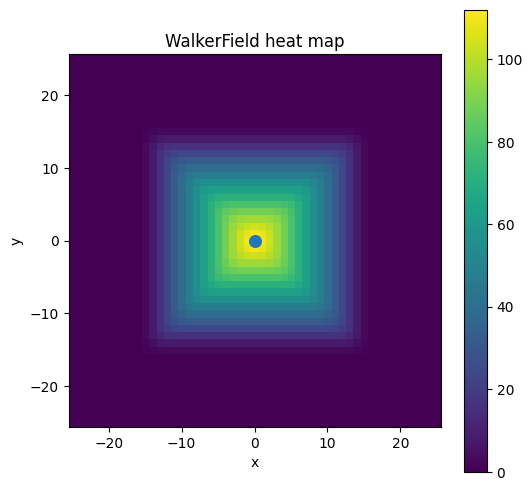

WalkerField(size=961/2601)

In [ ]:
RandomWalkerFDS.multi_step_field_generator(15)

In [ ]:
RandomWalkerFDS.evolve(4)
RandomWalkerFDS.transition_list

[VectorState(-1, 0)]

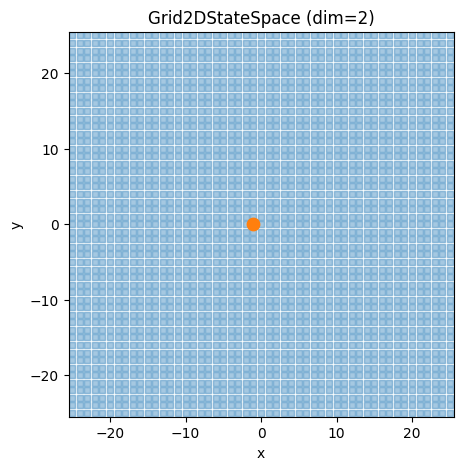

<Axes: title={'center': 'Grid2DStateSpace (dim=2)'}, xlabel='x', ylabel='y'>

In [ ]:
RandomWalkerFDS.state_space.plotSpace()

# 6 FOLD SYMMETRY WALKER

## Real Walker

### State

In [ ]:
from typing import Union
from dataclasses import dataclass

"""Defining a 2D vector"""




@dataclass(frozen=True, slots=True)
class GridState(State):
    """
    Immutable 2D integer-lattice state.
    Only basic vector ops live here to avoid entanglement with utilities.
    """

    x: int
    y: int

    def __post_init__(self) -> None:
        # normalize to ints (handles numpy scalars / float-integrals)
        object.__setattr__(self, "x", int(self.x))
        object.__setattr__(self, "y", int(self.y))


    def as_vector(self) -> Tuple[int, int]:
         return (self.x, self.y)


    # convenience
    def to_tuple(self) -> Tuple[int, int]:
        return (self.x, self.y)

    @classmethod
    def from_pair(cls, p: tuple) -> "GridState":
        t = p
        if len(t) != 2:
            raise ValueError(f"Expected length-2 pair, got {t!r}")
        return cls(int(t[0]), int(t[1]))

    def add(self,anotherState: GridState) -> GridState:
        return GridState(self.x+anotherState.x,self.y+anotherState.y)

    def subtract(self,anotherState: GridState) -> GridState:
        return GridState(self.x-anotherState.x,self.y-anotherState.y)

    # sugar (optional)
    def __add__(self, other: Union["GridState", Tuple[int, int]]) -> "GridState":
        return self.add(other)

    def __sub__(self, other: Union["GridState", Tuple[int, int]]) -> "GridState":
        return self.subtract(other)

    @property
    def dim(self) -> int:
        return 2

    def __iter__(self):
        yield self.x
        yield self.y


### State operations for Distance

In [ ]:
class EuclideanDistance(StateOperations):
    """√((x1-x2)^2 + (y1-y2)^2)"""
    def apply(self, a: GridState, b: GridState) -> float:
        ax, ay = a.as_vector()
        bx, by = b.as_vector()
        return math.hypot(ax - bx, ay - by)

class ChebyshevDistance(StateOperations):
    """max(|x1-x2|, |y1-y2|)"""
    def apply(self, a: GridState, b: GridState) -> int:
        ax, ay = a.as_vector()
        bx, by = b.as_vector()
        return max(abs(ax - bx), abs(ay - by))

### 6 fold state space

In [ ]:
class SixFoldLattice(StatSpace[GridState]):
    """
    Six-fold (hex/triangular) lattice on **axial integer coordinates** (q, r).

    States are GridState(q, r) with axial bounds:
      q ∈ [-X_l, X_l],  r ∈ [-Y_l, Y_l]  (inclusive)

    Conforms to the provided StatSpace API. Uses a simple __init__ + super().
    """

    def __init__(
        self,
        X_l: int,
        Y_l: int,
        initial_state: GridState = None,
        set_of_states: Optional[Set[GridState]] = None,
    ) -> None:
        self.X_l = int(X_l)
        self.Y_l = int(Y_l)
        if self.X_l < 0 or self.Y_l < 0:
            raise ValueError("X_l and Y_l must be ≥ 0")

        if initial_state is None:
            initial_state = GridState(0, 0)

        # Base class init manages current state and optional external set
        super().__init__(initial_state=initial_state, set_of_states = None )

        # Build full rectangular-axial lattice by default
        self._states: Set[GridState] = set()
        self.build()

        # If an explicit set is provided, adopt it (and tighten bounds)
        if set_of_states is not None:
            self.build_from_states(set_of_states, current=initial_state)

        if not self.contains(self.get_state()):
            raise ValueError("initial_state must be within the lattice bounds")

    # ---------- StatSpace interface ----------
    def get_all_states(self) -> Set[GridState]:
        return set(self._states)

    def dimension(self) -> int:
        return 2

    def build(self, *args, **kwargs) -> None:
        """(Re)build states from current X_l, Y_l bounds."""
        states: Set[GridState] = set()
        for q in range(-self.X_l, self.X_l + 1):
            for r in range(-self.Y_l, self.Y_l + 1):
                states.add(GridState(q, r))
        self._states = states

    def build_from_states(self, states: Set[GridState], current: Optional[GridState] = None) -> None:
        if not states:
            raise ValueError("states set cannot be empty")
        # Adopt tight bounds that cover the provided states
        max_abs_q = max(abs(s.x) for s in states)
        max_abs_r = max(abs(s.y) for s in states)
        self.X_l = int(max_abs_q)
        self.Y_l = int(max_abs_r)
        self._states = set(states)
        if current is not None:
            if current not in self._states:
                raise ValueError("provided current state is not in states")
            self.set_state(current)

    # ---------- Additional lattice utilities ----------
    @staticmethod
    def hex_distance(a: GridState, b: GridState) -> int:
        dq = a.x - b.x
        dr = a.y - b.y
        ds = -(dq + dr)
        return (abs(dq) + abs(dr) + abs(ds)) // 2

    def contains(self, s: GridState) -> bool:
        return s in self._states

    def neighbors(self, s: GridState, radius: int = 1, allow_stationary: bool = False) -> List[GridState]:
        if radius < 0:
            raise ValueError("radius must be ≥ 0")
        if s not in self._states:
            return []
        out: List[GridState] = []
        for cand in self._states:
            d = self.hex_distance(s, cand)
            if d == 0 and not allow_stationary:
                continue
            if d <= radius:
                out.append(cand)
        return out

    def ring(self, s: GridState, k: int) -> List[GridState]:
        if k < 0:
            raise ValueError("k must be ≥ 0")
        return [c for c in self._states if self.hex_distance(s, c) == k]

    def clamp(self, s: GridState) -> GridState:
        # Clamp to rectangular axial bounds then snap to an in-bounds state
        q = min(self.X_l, max(-self.X_l, s.x))
        r = min(self.Y_l, max(-self.Y_l, s.y))
        gs = GridState(q, r)
        return gs if gs in self._states else self.get_state()

    def to_cartesian(self, s: GridState, scale: float = 1.0) -> Tuple[float, float]:
        q, r = s.x, s.y
        x = (q + 0.5 * r) * scale
        y = (math.sqrt(3) * 0.5 * r) * scale
        return (x, y)

    # ---------- Visualization ----------
    def plot_state_space(
        self,
        scale: float = 1.0,
        ax=None,
        show: bool = True,
        annotate_initial: bool = False,
        point_kwargs: Optional[dict] = None,
        init_kwargs: Optional[dict] = None,
    ):
        """
        Scatter-plot the lattice states using axial→Cartesian mapping.

        Parameters
        ----------
        scale : float
            Visual scaling for the hex coordinates (affects spacing only).
        ax : matplotlib Axes or None
            If None, creates a new figure/axes.
        show : bool
            If True, calls plt.show() at the end.
        annotate_initial : bool
            If True, writes a small label next to the initial/current state.
        point_kwargs : dict
            Extra kwargs for all lattice points (e.g., {'s': 15, 'alpha': 0.6}).
        init_kwargs : dict
            Extra kwargs for the initial/current state point.
        """
        import matplotlib.pyplot as plt  # local import to keep dependency optional

        if point_kwargs is None:
            point_kwargs = {'s': 18, 'alpha': 0.6, 'linewidths': 0.0}
        if init_kwargs is None:
            init_kwargs = {'s': 64, 'color': 'blue', 'zorder': 3}

        # Map all states
        coords = [(s.x,s.y) for s in self._states]
        xs, ys = zip(*coords) if coords else ([], [])

        # Prepare axes
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            created_fig = True

        # Plot all lattice sites (light gray points)
        ax.scatter(xs, ys, c='#bbbbbb', **point_kwargs)

        # Highlight initial/current state in blue
        x0, y0 = (self.get_state().x,self.get_state().y)
        ax.scatter([x0], [y0], **init_kwargs)
        if annotate_initial:
            ax.annotate('initial', (x0, y0), textcoords='offset points', xytext=(6, 6), fontsize=9)

        ax.set_aspect('equal', adjustable='box')
        ax.set_title(f"SixFoldLattice: X_l={self.X_l}, Y_l={self.Y_l}")
        ax.set_xlabel('x (cartesian)')
        ax.set_ylabel('y (cartesian)')
        ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)

        if show and created_fig:
            plt.show()
        return ax

    # ---------- Set operations returning NEW spaces ----------
    def union_state_space(self, other: 'StatSpace[GridState]') -> 'SixFoldLattice':
        union_states = set(self.get_all_states()).union(other.get_all_states())
        if not union_states:
            raise ValueError("union produced no states")
        # Compute tight bounds
        max_abs_q = max(abs(s.x) for s in union_states)
        max_abs_r = max(abs(s.y) for s in union_states)
        init = self.get_state() if self.get_state() in union_states else next(iter(union_states))
        new_space = SixFoldLattice(max_abs_q, max_abs_r, initial_state=init)
        new_space.build_from_states(union_states, current=init)
        return new_space

    def intersection(self, other: 'StatSpace[GridState]') -> 'SixFoldLattice':
        inter_states = set(self.get_all_states()).intersection(other.get_all_states())
        if not inter_states:
            raise ValueError("intersection is empty")
        max_abs_q = max(abs(s.x) for s in inter_states)
        max_abs_r = max(abs(s.y) for s in inter_states)
        init = self.get_state() if self.get_state() in inter_states else next(iter(inter_states))
        new_space = SixFoldLattice(max_abs_q, max_abs_r, initial_state=init)
        new_space.build_from_states(inter_states, current=init)
        return new_space

In [ ]:
 L = SixFoldLattice(2, 2,GridState(1, 0))

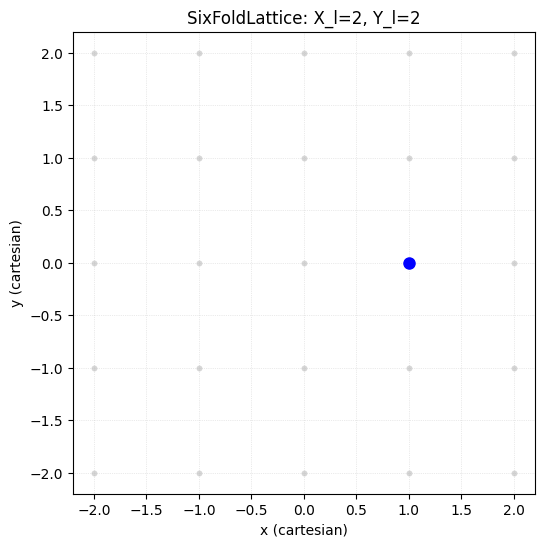

<Axes: title={'center': 'SixFoldLattice: X_l=2, Y_l=2'}, xlabel='x (cartesian)', ylabel='y (cartesian)'>

In [ ]:
L.plot_state_space()

### Cratesian State Space

In [ ]:
class CartesianStateSpace(StatSpace[GridState]):
    """
    A simple 2D Cartesian grid backed by `GridState` integers but parameterized
    with **X_l, Y_l** like `SixFoldLattice`.

    Real coordinates are represented on a uniform grid with step sizes
    `(step_x, step_y)`. The valid real ranges are:
        x ∈ [-X_l, X_l],  y ∈ [-Y_l, Y_l]
    and we encode a real (x, y) as integers via fixed-point:
        ix = round(x / step_x)  <=>  x ≈ ix * step_x
        iy = round(y / step_y)  <=>  y ≈ iy * step_y

    So the internal integer bounds are:
        ix ∈ [-floor(X_l/step_x), +floor(X_l/step_x)]
        iy ∈ [-floor(Y_l/step_y), +floor(Y_l/step_y)]
    """

    def __init__(
        self,
        X_l: float,
        Y_l: float,
        step_x: float = 1.0,
        step_y: float = 1.0,
        initial_xy: Tuple[float, float] = None,
        set_of_states: Optional[Set[GridState]] = None,
    ) -> None:
        if step_x <= 0 or step_y <= 0:
            raise ValueError("step_x and step_y must be > 0")
        if X_l < 0 or Y_l < 0:
            raise ValueError("X_l and Y_l must be ≥ 0")

        self.X_l = float(X_l)
        self.Y_l = float(Y_l)
        self.step_x = float(step_x)
        self.step_y = float(step_y)
        # fixed-point scales
        self.scale_x = 1.0 / self.step_x
        self.scale_y = 1.0 / self.step_y

        # choose initial real point
        if initial_xy is None:
            initial_xy = (0.0, 0.0)
        init_state = self.from_real(*initial_xy)

        # base init manages current state
        super().__init__(initial_state=init_state, set_of_states=None)

        # build states from X_l, Y_l and step sizes
        self._states: Set[GridState] = set()
        self.build()

        # optionally adopt provided set (already encoded)
        if set_of_states is not None:
            self.build_from_states(set_of_states, current=init_state)

        if not self.contains(self.get_state()):
            raise ValueError("initial state is out of bounds")

    # ---------- helpers: real/int mapping and bounds ----------
    def _ix_bounds(self) -> Tuple[int, int]:
        ix_lim = int(math.floor(self.X_l * self.scale_x))
        return (-ix_lim, ix_lim)

    def _iy_bounds(self) -> Tuple[int, int]:
        iy_lim = int(math.floor(self.Y_l * self.scale_y))
        return (-iy_lim, iy_lim)

    def from_real(self, x: float, y: float) -> GridState:
        ix = int(round(x * self.scale_x))
        iy = int(round(y * self.scale_y))
        return GridState(ix, iy)

    def to_real(self, s: GridState) -> Tuple[float, float]:
        return (s.x / self.scale_x, s.y / self.scale_y)

    # ---------- StatSpace interface ----------
    def build(self, *args, **kwargs) -> None:
        states: Set[GridState] = set()
        ix_min, ix_max = self._ix_bounds()
        iy_min, iy_max = self._iy_bounds()
        for ix in range(ix_min, ix_max + 1):
            for iy in range(iy_min, iy_max + 1):
                states.add(GridState(ix, iy))
        self._states = states

    def get_all_states(self) -> Set[GridState]:
        return set(self._states)

    def dimension(self) -> int:
        return 2

    def build_from_states(self, states: Set[GridState], current: Optional[GridState] = None) -> None:
        if not states:
            raise ValueError("states set cannot be empty")
        self._states = set(states)
        # infer tight integer bounds then convert to real extents
        xs = [abs(s.x) for s in self._states]
        ys = [abs(s.y) for s in self._states]
        self.X_l = max(xs) / self.scale_x if xs else 0.0
        self.Y_l = max(ys) / self.scale_y if ys else 0.0
        if current is not None:
            if current not in self._states:
                raise ValueError("provided current state is not in states")
            self.set_state(current)

    # ---------- membership & neighbors ----------
    def contains(self, s: GridState) -> bool:
        return s in self._states

    def contains_real(self, x: float, y: float) -> bool:
        return self.from_real(x, y) in self._states

    def neighbors(
        self,
        s: GridState,
        radius: int = 1,
        allow_stationary: bool = False,
        connectivity: int = 4,
    ) -> List[GridState]:
        if radius < 0:
            raise ValueError("radius must be ≥ 0")
        if s not in self._states:
            return []
        out: List[GridState] = []
        ix0, iy0 = s.x, s.y
        if radius == 0:
            return [s] if allow_stationary else []
        for dx in range(-radius, radius + 1):
            for dy in range(-radius, radius + 1):
                if dx == 0 and dy == 0 and not allow_stationary:
                    continue
                cand = GridState(ix0 + dx, iy0 + dy)
                if cand not in self._states:
                    continue
                if connectivity == 4:
                    if abs(dx) + abs(dy) <= radius:  # Manhattan ball
                        out.append(cand)
                elif connectivity == 8:
                    if max(abs(dx), abs(dy)) <= radius:  # Chebyshev ball
                        out.append(cand)
                else:
                    raise ValueError("connectivity must be 4 or 8")
        return out

    def ring(self, s: GridState, k: int, connectivity: int = 4) -> List[GridState]:
        if k < 0:
            raise ValueError("k must be ≥ 0")
        out: List[GridState] = []
        ix0, iy0 = s.x, s.y
        for dx in range(-k, k + 1):
            for dy in range(-k, k + 1):
                cand = GridState(ix0 + dx, iy0 + dy)
                if cand not in self._states:
                    continue
                if connectivity == 4 and (abs(dx) + abs(dy) == k):
                    out.append(cand)
                if connectivity == 8 and (max(abs(dx), abs(dy)) == k):
                    out.append(cand)
        return out

    def clamp(self, s: GridState) -> GridState:
        ix_min, ix_max = self._ix_bounds()
        iy_min, iy_max = self._iy_bounds()
        ix = min(ix_max, max(ix_min, s.x))
        iy = min(iy_max, max(iy_min, s.y))
        gs = GridState(ix, iy)
        return gs if gs in self._states else self.get_state()

    # ---------- visualization ----------
    def plot_state_space(
        self,
        ax=None,
        show: bool = True,
        annotate_initial: bool = False,
        point_kwargs: Optional[dict] = None,
        init_kwargs: Optional[dict] = None,
    ):
        import matplotlib.pyplot as plt
        if point_kwargs is None:
            point_kwargs = {'s': 16, 'alpha': 0.6, 'linewidths': 0.0}
        if init_kwargs is None:
            init_kwargs = {'s': 64, 'color': 'blue', 'zorder': 3}
        coords = [self.to_real(s) for s in self._states]
        xs, ys = zip(*coords) if coords else ([], [])
        created_fig = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            created_fig = True
        ax.scatter(xs, ys, c='#bbbbbb', **point_kwargs)
        x0, y0 = self.to_real(self.get_state())
        ax.scatter([x0], [y0], **init_kwargs)
        if annotate_initial:
            ax.annotate('initial', (x0, y0), textcoords='offset points', xytext=(6, 6), fontsize=9)
        ax.set_aspect('equal', adjustable='box')
        ax.set_title(
            f"CartesianStateSpace: X_l={self.X_l}, Y_l={self.Y_l}; step=({self.step_x},{self.step_y})"
        )
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.grid(True, linestyle=':', linewidth=0.5, alpha=0.5)
        if show and created_fig:
            plt.show()
        return ax

    # ---------- set operations (require matching steps) ----------
    def union_state_space(self, other: CartesianStateSpace) -> 'CartesianStateSpace':
        if (self.step_x != other.step_x) or (self.step_y != other.step_y):
            raise ValueError("step sizes must match for union")
        union_states = set(self.get_all_states()).union(other.get_all_states())
        if not union_states:
            raise ValueError("union produced no states")
        max_abs_ix = max(abs(s.x) for s in union_states)
        max_abs_iy = max(abs(s.y) for s in union_states)
        new_space = CartesianStateSpace(
            X_l=max_abs_ix / self.scale_x,
            Y_l=max_abs_iy / self.scale_y,
            step_x=self.step_x,
            step_y=self.step_y,
            initial_xy=self.to_real(self.get_state()),
        )
        new_space.build_from_states(union_states, current=self.get_state())
        return new_space

    def intersection(self, other: 'CartesianStateSpace[GridState]') -> 'CartesianStateSpace':
        if (self.step_x != other.step_x) or (self.step_y != other.step_y):
            raise ValueError("step sizes must match for intersection")
        inter_states = set(self.get_all_states()).intersection(other.get_all_states())
        if not inter_states:
            raise ValueError("intersection is empty")
        max_abs_ix = max(abs(s.x) for s in inter_states)
        max_abs_iy = max(abs(s.y) for s in inter_states)
        init = self.get_state() if self.get_state() in inter_states else next(iter(inter_states))
        new_space = CartesianStateSpace(
            X_l=max_abs_ix / self.scale_x,
            Y_l=max_abs_iy / self.scale_y,
            step_x=self.step_x,
            step_y=self.step_y,
            initial_xy=self.to_real(init),
        )
        new_space.build_from_states(inter_states, current=init)
        return new_space




In [ ]:

 C = CartesianStateSpace(10,10,0.1,0.1,initial_xy=(0.0, 0.0))

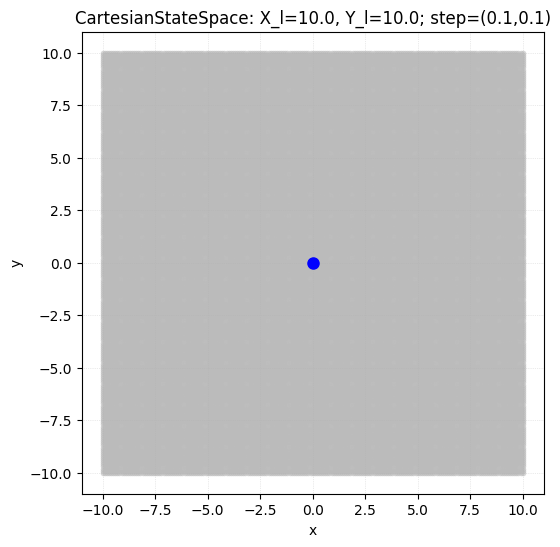

<Axes: title={'center': 'CartesianStateSpace: X_l=10.0, Y_l=10.0; step=(0.1,0.1)'}, xlabel='x', ylabel='y'>

In [ ]:
C.plot_state_space()

### State Space Mapping

#### 6 fold Symmetric Lattice to Cartesian

In [ ]:
class LatticeToCartesian(StateSpaceMapping[GridState, GridState]):
    """
    Map a **SixFoldLattice axial state** (q, r) to a **CartesianStateSpace**
    state using the standard axial→Cartesian transform:

        x = q + 0.5*r
        y = (√3/2) * r

    The result is encoded into the target `CartesianStateSpace` via its
    fixed-point `from_real(x, y)` method. The returned space is the provided
    `stateSpaceOut` narrowed to a singleton containing the mapped state.
    """

    def __init__(self, scale: float = 1.0, mapping_reverse: Optional['StateSpaceMapping[GridState, GridState]'] = None) -> None:
        super().__init__(mapping_reverse=mapping_reverse)
        self.scale = float(scale)

    def _axial_to_cartesian(self, q: int, r: int) -> Tuple[float, float]:
        x = (q + 0.5 * r) * self.scale
        y = (math.sqrt(3) * 0.5 * r) * self.scale
        return (x, y)

    def get_mapping(self, state_in: GridState, stateSpaceOut: CartesianStateSpace) -> CartesianStateSpace:
        q, r = state_in.x, state_in.y
        x, y = self._axial_to_cartesian(q, r)
        mapped_state = stateSpaceOut.from_real(x, y)
        # Replace contents of the provided space with the singleton {mapped_state}
        stateSpaceOut.build_from_states({mapped_state}, current=mapped_state)
        return stateSpaceOut


In [ ]:
mapper = LatticeToCartesian(1)

In [ ]:
C = mapper.get_mapping_over_state_space(L,C)

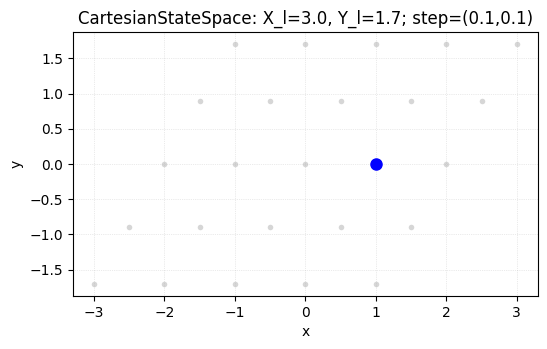

<Axes: title={'center': 'CartesianStateSpace: X_l=3.0, Y_l=1.7; step=(0.1,0.1)'}, xlabel='x', ylabel='y'>

In [ ]:
C.plot_state_space()

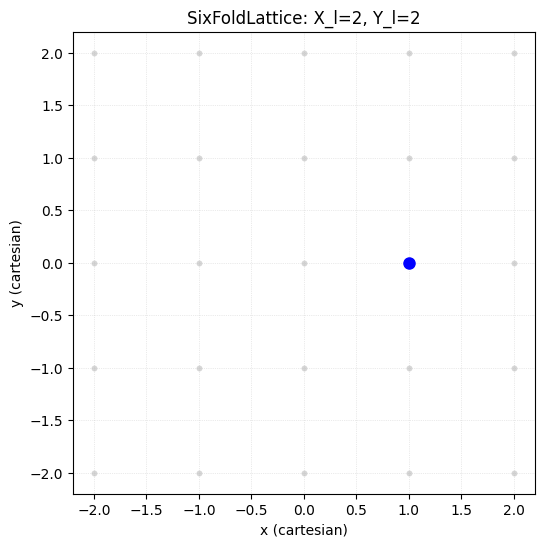

<Axes: title={'center': 'SixFoldLattice: X_l=2, Y_l=2'}, xlabel='x (cartesian)', ylabel='y (cartesian)'>

In [ ]:
L.plot_state_space()

#### Cartesian to 6 fold Symmetry

In [ ]:
class CartesianToLattice(StateSpaceMapping[GridState, GridState]):
    def __init__(self, *, cart_source: 'CartesianStateSpace', scale: float = 1.0, mapping_reverse: Optional['StateSpaceMapping[GridState, GridState]'] = None) -> None:
        super().__init__(mapping_reverse=mapping_reverse)
        self.cart_source = cart_source
        self.scale = float(scale)

    @staticmethod
    def _cube_round(qf: float, rf: float) -> Tuple[int, int]:
        xf = qf
        zf = rf
        yf = -xf - zf
        rx = round(xf)
        ry = round(yf)
        rz = round(zf)
        x_diff = abs(rx - xf)
        y_diff = abs(ry - yf)
        z_diff = abs(rz - zf)
        if x_diff > y_diff and x_diff > z_diff:
            rx = -ry - rz
        elif y_diff > z_diff:
            ry = -rx - rz
        else:
            rz = -rx - ry
        return int(rx), int(rz)

    def _cartesian_to_axial_floats(self, x: float, y: float) -> Tuple[float, float]:
        r_f = (2.0 / math.sqrt(3.0)) * (y / self.scale)
        q_f = (x / self.scale) - 0.5 * r_f
        return q_f, r_f

    def get_mapping(self, state_in: GridState, stateSpaceOut: StatSpace) -> StatSpace[GridState]:
        if not isinstance(stateSpaceOut, SixFoldLattice):
            raise TypeError("CartesianToLattice expects a SixFoldLattice as output")
        x, y = self.cart_source.to_real(state_in)
        qf, rf = self._cartesian_to_axial_floats(x, y)
        q, r = self._cube_round(qf, rf)
        mapped_state = GridState(q, r)
        stateSpaceOut.build_from_states({mapped_state}, current=mapped_state)
        return stateSpaceOut

In [ ]:

reverseMapper = CartesianToLattice(cart_source=C,scale=1)

In [ ]:
L = SixFoldLattice(2, 2,GridState(0, 0))
C = CartesianStateSpace(10,10,0.1,0.1,initial_xy=(0.0, 0.0))

L = reverseMapper.get_mapping_over_state_space(C,L)

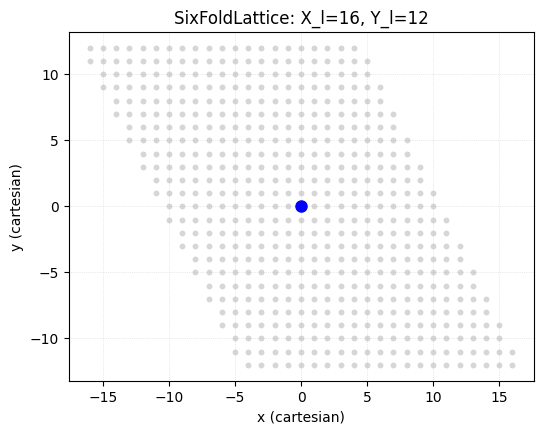

<Axes: title={'center': 'SixFoldLattice: X_l=16, Y_l=12'}, xlabel='x (cartesian)', ylabel='y (cartesian)'>

In [ ]:
L.plot_state_space()

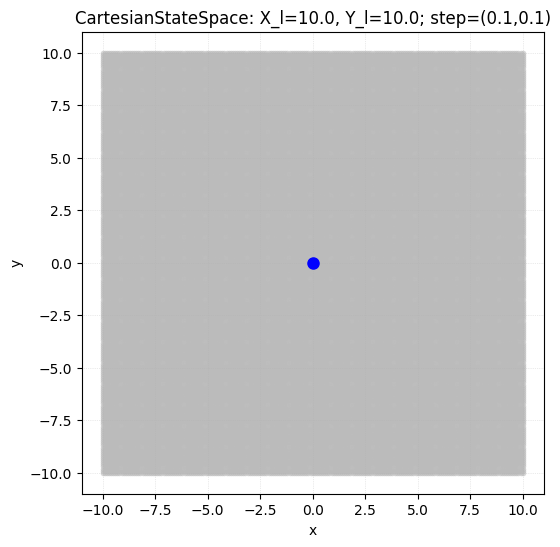

<Axes: title={'center': 'CartesianStateSpace: X_l=10.0, Y_l=10.0; step=(0.1,0.1)'}, xlabel='x', ylabel='y'>

In [ ]:
C.plot_state_space()

### Random Walker State

#### 6 Fold symmetric State

In [ ]:
class SixFoldRandomWalkerState(State):
    __slots__ = ("position", "dir_idx")
    DIR_INDEX_TO_DELTA: Tuple[Tuple[int, int], ...] = (
        (0, 0),
        (0, 1),
        (-1, 1),
        (-1, 0),
        (0, -1),
        (1, -1),
        (1, 0),
    )
    DELTA_TO_DIR_INDEX = {d: i for i, d in enumerate(DIR_INDEX_TO_DELTA)}

    def __init__(self, position: GridState, direction: int = 0) -> None:
        self.position = position
        self.dir_idx = int(direction) % 7

    def as_vector(self) -> Tuple[int, int]:
        return self.position.as_vector()

    def direction_delta(self) -> Tuple[int, int]:
        return self.DIR_INDEX_TO_DELTA[self.dir_idx]

    def next_position(self) -> GridState:
        dq, dr = self.direction_delta()
        return GridState(self.position.x + dq, self.position.y + dr)

    def __eq__(self, other: SixFoldRandomWalkerState) -> bool:
        if isinstance(other, SixFoldRandomWalkerState):
            return self.position == other.position and self.dir_idx == other.dir_idx

    def __hash__(self) -> int:
        return hash((self.position, self.dir_idx))

#### Cartesian RandomWalker State

In [ ]:
class CartesianRandomWalkerState(State):
    __slots__ = ("position", "direction")
    def __init__(self, position: GridState, direction: GridState) -> None:
        if not isinstance(position, GridState):
            raise TypeError("position must be GridState")
        if not isinstance(direction, GridState):
            raise TypeError("direction must be GridState")
        self.position = position
        self.direction = direction
    def as_vector(self) -> Tuple[int, int]:
        return self.position.as_vector()

    def __hash__(self) -> int:
        return hash((self.position, self.direction))

    def __eq__(self, other: CartesianRandomWalkerState) -> bool:
        if isinstance(other, CartesianRandomWalkerState):
            return self.position == other.position and self.direction == other.direction
    def direction_delta(self) -> Tuple[int, int]:
        return self.DIR_INDEX_TO_DELTA[self.dir_idx]

### Random Walker State Operations

In [ ]:
class EuclideanDistanceRandomWalker(StateOperations):
    def apply(self, a: SixFoldRandomWalkerState, b: SixFoldRandomWalkerState) -> float:
        ax, ay = a.as_vector()
        bx, by = b.as_vector()
        return math.hypot(ax - bx, ay - by)

class ChebyshevDistanceRandomWalker(StateOperations):
    def apply(self, a: SixFoldRandomWalkerState, b: SixFoldRandomWalkerState) -> int:
        ax, ay = a.as_vector()
        bx, by = b.as_vector()
        return max(abs(ax - bx), abs(ay - by))

### 6 Fold Random Walker State Space

In [ ]:
class SixFoldRandomWalkerStateSpace(StatSpace[SixFoldRandomWalkerState]):
    def __init__(
        self,
        X_l: int,
        Y_l: int,
        initial_state: SixFoldRandomWalkerState = None,
        set_of_states: Optional[Set[SixFoldRandomWalkerState]] = None,
    ) -> None:
        self.X_l = int(X_l)
        self.Y_l = int(Y_l)
        if self.X_l < 0 or self.Y_l < 0:
            raise ValueError("X_l and Y_l must be ≥ 0")
        if initial_state is None:
            initial_state = SixFoldRandomWalkerState(GridState(0, 0), 0)
        self._layers: Tuple[SixFoldLattice, ...] = tuple(
            SixFoldLattice(self.X_l, self.Y_l, initial_state=initial_state.position)
            for _ in range(7)
        )
        super().__init__(initial_state=initial_state, set_of_states=None)
        self._states: Set[SixFoldRandomWalkerState] = set()
        self.build()
        if set_of_states is not None:
            self.build_from_states(set_of_states, current=initial_state)
        if not self.contains(initial_state):
            raise ValueError("initial_state out of bounds")

    def build(self, *args, **kwargs) -> None:
        base_positions = self._layers[0].get_all_states()
        states: Set[SixFoldRandomWalkerState] = set()
        for pos in base_positions:
            for d in range(7):
                states.add(SixFoldRandomWalkerState(pos, d))
        self._states = states

    def build_from_states(self, states: Set[SixFoldRandomWalkerState], current: Optional[SixFoldRandomWalkerState] = None) -> SixFoldRandomWalkerStateSpace:
        if not states:
            raise ValueError("states set cannot be empty")
        self._states = set(states)
        xs = [abs(s.position.x) for s in self._states]
        ys = [abs(s.position.y) for s in self._states]
        self.X_l = max(xs) if xs else 0
        self.Y_l = max(ys) if ys else 0
        self._layers = tuple(SixFoldLattice(self.X_l, self.Y_l, initial_state=(current.position if current else GridState(0, 0))) for _ in range(7))
        if current is not None:
          self.set_state(current)
        return self

    def get_all_states(self) -> Set[SixFoldRandomWalkerState]:
        return set(self._states)

    def dimension(self) -> int:
        return 2

    def contains(self, s: SixFoldRandomWalkerState) -> bool:
        return s in self._states

    def union_state_space(self, other: 'StatSpace[SixFoldRandomWalkerState]') -> 'SixFoldRandomWalkerStateSpace':
        if not isinstance(other, SixFoldRandomWalkerStateSpace):
            raise TypeError("union_state_space requires another SixFoldRandomWalkerStateSpace")
        union_states = set(self.get_all_states()).union(other.get_all_states())
        if not union_states:
            raise ValueError("union produced no states")
        max_abs_q = max(abs(s.position.x) for s in union_states)
        max_abs_r = max(abs(s.position.y) for s in union_states)
        init = self.get_state() if self.get_state() in union_states else next(iter(union_states))
        new_space = SixFoldRandomWalkerStateSpace(max_abs_q, max_abs_r, initial_state=init)
        new_space.build_from_states(union_states, current=init)
        return new_space

    def intersection(self, other: 'StatSpace[SixFoldRandomWalkerState]') -> 'SixFoldRandomWalkerStateSpace':
        if not isinstance(other, SixFoldRandomWalkerStateSpace):
            raise TypeError("intersection requires another SixFoldRandomWalkerStateSpace")
        inter_states = set(self.get_all_states()).intersection(other.get_all_states())
        if not inter_states:
            raise ValueError("intersection is empty")
        max_abs_q = max(abs(s.position.x) for s in inter_states)
        max_abs_r = max(abs(s.position.y) for s in inter_states)
        init = self.get_state() if self.get_state() in inter_states else next(iter(inter_states))
        new_space = SixFoldRandomWalkerStateSpace(max_abs_q, max_abs_r, initial_state=init)
        new_space.build_from_states(inter_states, current=init)
        return new_space

    def plot_state_space(
        self,
        scale: float = 1.0,
        ax=None,
        show: bool = True,
        annotate_initial: bool = False,
        point_kwargs: Optional[dict] = None,
        init_kwargs: Optional[dict] = None,
    ):
        import matplotlib.pyplot as plt
        s0 = self.get_state()
        base = SixFoldLattice(self.X_l, self.Y_l, initial_state=s0.position)
        ax = base.plot_state_space(
            scale=scale,
            ax=ax,
            show=False,
            annotate_initial=annotate_initial,
            point_kwargs=point_kwargs,
            init_kwargs=init_kwargs,
        )
        head = s0.next_position()
        if base.contains(head):
            x0, y0 = (s0.position.x, s0.position.y)
            x1, y1 = (head.x, head.y)
            ax.annotate('', xy=(x1, y1), xytext=(x0, y0), arrowprops=dict(arrowstyle='->', lw=1.5, color='blue'))
        if show:
            plt.show()
        return ax


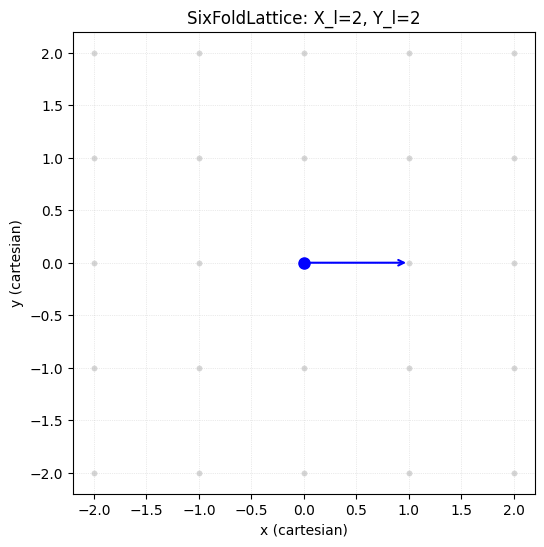

<Axes: title={'center': 'SixFoldLattice: X_l=2, Y_l=2'}, xlabel='x (cartesian)', ylabel='y (cartesian)'>

In [ ]:
sex = SixFoldRandomWalkerStateSpace(2,2,SixFoldRandomWalkerState(GridState(0,0),6))
sex.plot_state_space()

### Cartesian Random Walker State Space

In [ ]:


# expects:
# from your_module import State, StatSpace, GridState, CartesianStateSpace

_HEX_DIRS_AXIAL: Tuple[Tuple[int, int], ...] = (
    (0, 0),
    (0, 1),
    (-1, 1),
    (-1, 0),
    (0, -1),
    (1, -1),
    (1, 0),
)


class CartesianRandomWalkerState(State):
    __slots__ = ("position", "dir_idx")

    def __init__(self, position: GridState, dir_idx: int = 0) -> None:
        if not isinstance(position, GridState):
            raise TypeError("position must be GridState")
        self.position = position
        self.dir_idx = int(dir_idx) % 7

    def as_vector(self) -> Tuple[int, int]:
        return self.position.as_vector()

    def __eq__(self, other: object) -> bool:
        if isinstance(other, CartesianRandomWalkerState):
            return self.position == other.position and self.dir_idx == other.dir_idx
        return False

    def __hash__(self) -> int:
        return hash((self.position, self.dir_idx))


class CartesianRandomWalkerStateSpace(StatSpace[CartesianRandomWalkerState]):
    """
    Cartesian random-walker whose *positions* are exactly the image of an axial
    hex lattice under the standard axial→Cartesian mapping:

        x = (q + 0.5 r) * scale
        y = (√3/2 r) * scale

    The allowed directions are the 6 axial steps (plus stationary) mapped into
    Cartesian index space. Plotting shows a hexagonal lattice (hex centers).
    """

    def __init__(
        self,
        X_l: int,
        Y_l: int,
        initial_state: Optional[CartesianRandomWalkerState] = None,
        *,
        scale: float = 1.0,
        step_x: float = None,
        step_y: float = None,
        set_of_states: Optional[Set[CartesianRandomWalkerState]] = None,
    ) -> None:
        self.X_l_axial = int(X_l)
        self.Y_l_axial = int(Y_l)
        if self.X_l_axial < 0 or self.Y_l_axial < 0:
            raise ValueError("X_l and Y_l must be ≥ 0")

        # Default steps that align perfectly with the hex mapping
        if step_x is None:
            step_x = 0.5 * scale
        if step_y is None:
            step_y = (math.sqrt(3) / 2.0) * scale
        self.scale = float(scale)

        # Real extents that cover the mapped hex rectangle
        X_l_real = (self.X_l_axial + 0.5 * self.Y_l_axial) * self.scale
        Y_l_real = (math.sqrt(3) / 2.0) * self.Y_l_axial * self.scale

        # Backing Cartesian grid (for fixed-point encoding and plotting)
        self._base = CartesianStateSpace(
            X_l=X_l_real, Y_l=Y_l_real, step_x=step_x, step_y=step_y, initial_xy=(0.0, 0.0)
        )

        # Precompute direction deltas in *index* space induced by axial steps
        self._dir_ixiy: Tuple[Tuple[int, int], ...] = self._compute_hex_cartesian_deltas()

        # Build mapped positions set
        self._positions: Set[GridState] = self._build_mapped_positions()

        # Choose default initial state on the mapped origin
        if initial_state is None:
            origin_idx = self._map_axial_to_cart_index(0, 0)
            initial_state = CartesianRandomWalkerState(origin_idx, 0)

        super().__init__(initial_state=initial_state, set_of_states=None)

        # Enumerate states = positions × {0..6}
        self._states: Set[CartesianRandomWalkerState] = set()
        self.build()

        if set_of_states is not None:
            self.build_from_states(set_of_states, current=initial_state)

        if not self.contains(initial_state):
            raise ValueError("initial_state out of bounds")

    # ---------- mapping helpers ----------

    def _axial_to_real(self, q: int, r: int) -> Tuple[float, float]:
        x = (q + 0.5 * r) * self.scale
        y = (math.sqrt(3) * 0.5 * r) * self.scale
        return (x, y)

    def _map_axial_to_cart_index(self, q: int, r: int) -> GridState:
        x, y = self._axial_to_real(q, r)
        return self._base.from_real(x, y)

    def _build_mapped_positions(self) -> Set[GridState]:
        out: Set[GridState] = set()
        for q in range(-self.X_l_axial, self.X_l_axial + 1):
            for r in range(-self.Y_l_axial, self.Y_l_axial + 1):
                out.add(self._map_axial_to_cart_index(q, r))
        return out

    def _compute_hex_cartesian_deltas(self) -> Tuple[Tuple[int, int], ...]:
        sx, sy = self._base.step_x, self._base.step_y
        out: List[Tuple[int, int]] = []
        for dq, dr in _HEX_DIRS_AXIAL:
            dx = (dq + 0.5 * dr) * self.scale
            dy = (math.sqrt(3) * 0.5 * dr) * self.scale
            dix = int(round(dx / sx))
            diy = int(round(dy / sy))
            out.append((dix, diy))
        return tuple(out)

    def _head_index(self, s: CartesianRandomWalkerState) -> GridState:
        dix, diy = self._dir_ixiy[s.dir_idx]
        target = GridState(s.position.x + dix, s.position.y + diy)
        return self._base.clamp(target)

    # ---------- StatSpace interface ----------

    def build(self, *args, **kwargs) -> None:
        states: Set[CartesianRandomWalkerState] = set()
        for pos in self._positions:
            for i in range(7):
                states.add(CartesianRandomWalkerState(pos, i))
        self._states = states

    def build_from_states(
        self,
        states: Set[CartesianRandomWalkerState],
        current: Optional[CartesianRandomWalkerState] = None,
    ) -> None:
        if not states:
            raise ValueError("states set cannot be empty")
        self._states = set(states)
        self._positions = {s.position for s in self._states}
        if current is not None:
            if current not in self._states:
                raise ValueError("provided current state is not in states")
            self.set_state(current)

    def get_all_states(self) -> Set[CartesianRandomWalkerState]:
        return set(self._states)

    def dimension(self) -> int:
        return 2

    def get_state(self) -> CartesianRandomWalkerState:
        return super().get_state()

    def set_state(self, state: CartesianRandomWalkerState) -> None:
        if state.position not in self._positions:
            # snap to nearest mapped pos by simple clamp-then-nearest; here we clamp only
            clamped = self._base.clamp(state.position)
            # if clamp still not in positions (edge), fall back to current
            state = (
                CartesianRandomWalkerState(clamped, state.dir_idx)
                if clamped in self._positions
                else self.get_state()
            )
        super().set_state(state)

    def contains(self, s: CartesianRandomWalkerState) -> bool:
        return s in self._states

    # ---------- set ops (positions + dir indices) ----------

    def union_state_space(
        self, other: "StatSpace[CartesianRandomWalkerState]"
    ) -> "CartesianRandomWalkerStateSpace":
        if not isinstance(other, CartesianRandomWalkerStateSpace):
            raise TypeError("union_state_space requires another CartesianRandomWalkerStateSpace")
        union_states = set(self.get_all_states()).union(other.get_all_states())
        if not union_states:
            raise ValueError("union produced no states")
        init = self.get_state() if self.get_state() in union_states else next(iter(union_states))
        # reuse this space’s geometry/steps/scale
        new_space = CartesianRandomWalkerStateSpace(
            self.X_l_axial,
            self.Y_l_axial,
            initial_state=init,
            scale=self.scale,
            step_x=self._base.step_x,
            step_y=self._base.step_y,
        )
        new_space.build_from_states(union_states, current=init)
        return new_space

    def intersection(
        self, other: "StatSpace[CartesianRandomWalkerState]"
    ) -> "CartesianRandomWalkerStateSpace":
        if not isinstance(other, CartesianRandomWalkerStateSpace):
            raise TypeError("intersection requires another CartesianRandomWalkerStateSpace")
        inter_states = set(self.get_all_states()).intersection(other.get_all_states())
        if not inter_states:
            raise ValueError("intersection is empty")
        init = self.get_state() if self.get_state() in inter_states else next(iter(inter_states))
        new_space = CartesianRandomWalkerStateSpace(
            self.X_l_axial,
            self.Y_l_axial,
            initial_state=init,
            scale=self.scale,
            step_x=self._base.step_x,
            step_y=self._base.step_y,
        )
        new_space.build_from_states(inter_states, current=init)
        return new_space

    # ---------- visualization (hex look) ----------

    def plot_state_space(
        self,
        ax=None,
        show: bool = True,
        annotate_initial: bool = False,
        point_kwargs: Optional[dict] = None,
        init_kwargs: Optional[dict] = None,
    ):
        import matplotlib.pyplot as plt

        if point_kwargs is None:
            point_kwargs = {"s": 16, "alpha": 0.6, "linewidths": 0.0}
        if init_kwargs is None:
            init_kwargs = {"s": 64, "color": "blue", "zorder": 3}

        # Map our positions to real coordinates for plotting — these are hex centers
        coords = [self._base.to_real(p) for p in self._positions]
        xs, ys = zip(*coords) if coords else ([], [])

        created = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            created = True

        ax.scatter(xs, ys, c="#bbbbbb", **point_kwargs)

        s0 = self.get_state()
        tail_x, tail_y = self._base.to_real(s0.position)
        ax.scatter([tail_x], [tail_y], **init_kwargs)
        if annotate_initial:
            ax.annotate("initial", (tail_x, tail_y), textcoords="offset points", xytext=(6, 6), fontsize=9)

        head_idx = self._head_index(s0)
        head_x, head_y = self._base.to_real(head_idx)
        if (head_x, head_y) != (tail_x, tail_y):
            ax.annotate("", xy=(head_x, head_y), xytext=(tail_x, tail_y),
                        arrowprops=dict(arrowstyle="->", lw=1.5, color="blue"))

        ax.set_aspect("equal", adjustable="box")
        ax.set_title("CartesianRandomWalkerStateSpace (hex-mapped)")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.5)

        if show and created:
            plt.show()
        return ax


In [ ]:
RWC = CartesianRandomWalkerStateSpace(10,10,CartesianRandomWalkerState( GridState(0,0),1))

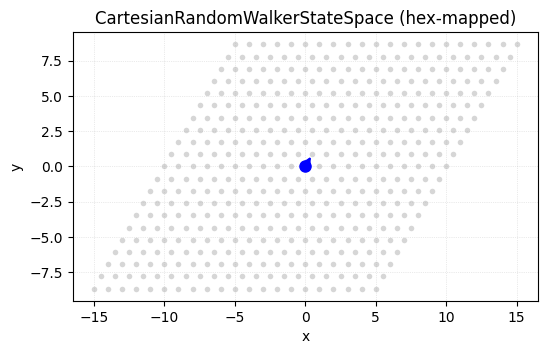

<Axes: title={'center': 'CartesianRandomWalkerStateSpace (hex-mapped)'}, xlabel='x', ylabel='y'>

In [ ]:
RWC.plot_state_space()

### 6 fold random walker to Cartesian mapping

In [ ]:


# expected from your codebase:
# from your_module import (
#     State, GridState, StatSpace,
#     SixFoldRandomWalkerState, SixFoldRandomWalkerStateSpace,
#     CartesianRandomWalkerState, CartesianRandomWalkerStateSpace,
# )

class SixFoldRWToCartesianRW(StateSpaceMapping[SixFoldRandomWalkerState, CartesianRandomWalkerState]):
    """
    Map a SixFoldRandomWalkerState (axial position + dir_idx) to a
    CartesianRandomWalkerState in a CartesianRandomWalkerStateSpace.

    Position mapping:
        x = (q + 0.5*r) * scale
        y = (sqrt(3)/2 * r) * scale
      then encoded to the target Cartesian grid via its step sizes.

    Direction mapping:
      - If the target state's current sample has attribute `dir_idx`, we copy
        the index 0..6 verbatim.
      - Else if it has `direction` (GridState), we convert each axial step
        (dq,dr) into Cartesian index deltas by rounding:
           dix = round( ((dq + 0.5*dr)*scale) / step_x )
           diy = round( ((sqrt(3)/2*dr)*scale) / step_y )
    """

    def __init__(self, *, scale: float = 1.0) -> None:
        super().__init__(mapping_reverse=None)
        self.scale = float(scale)

    # --- helpers ---
    @staticmethod
    def _dir_axial(idx: int) -> Tuple[int, int]:
        dirs = (
            (0, 0),
            (0, 1),
            (-1, 1),
            (-1, 0),
            (0, -1),
            (1, -1),
            (1, 0),
        )
        return dirs[int(idx) % 7]

    def _axial_to_real(self, q: int, r: int) -> Tuple[float, float]:
        x = (q + 0.5 * r) * self.scale
        y = (math.sqrt(3) * 0.5 * r) * self.scale
        return x, y

    def _dir_to_cart_index_vec(self, dq: int, dr: int, step_x: float, step_y: float) -> GridState:
        dx = (dq + 0.5 * dr) * self.scale
        dy = (math.sqrt(3) * 0.5 * dr) * self.scale
        dix = int(round(dx / step_x))
        diy = int(round(dy / step_y))
        return GridState(dix, diy)

    # --- core ---
    def get_mapping(
        self,
        state_in: SixFoldRandomWalkerState,
        stateSpaceOut: StatSpace
    ) -> StatSpace[CartesianRandomWalkerState]:
        # We need access to the target Cartesian grid steps (step_x, step_y) and
        # to encode real→index. Your CartesianRandomWalkerStateSpace typically
        # wraps a base CartesianStateSpace as `._base`.
        if not hasattr(stateSpaceOut, "_base"):
            raise TypeError("Expected a CartesianRandomWalkerStateSpace with a `_base` CartesianStateSpace")
        base = stateSpaceOut._base  # CartesianStateSpace
        step_x, step_y = base.step_x, base.step_y

        # 1) map axial position -> real -> target index
        q, r = state_in.position.x, state_in.position.y
        x_real, y_real = self._axial_to_real(q, r)
        pos_idx: GridState = base.from_real(x_real, y_real)

        # 2) map direction
        if hasattr(stateSpaceOut.get_state(), "dir_idx"):
            # target state stores direction by 0..6 index
            out_state = CartesianRandomWalkerState(pos_idx, state_in.dir_idx)
        elif hasattr(stateSpaceOut.get_state(), "direction"):
            # target state stores a vector direction
            dq, dr = self._dir_axial(state_in.dir_idx)
            vec = self._dir_to_cart_index_vec(dq, dr, step_x, step_y)
            out_state = CartesianRandomWalkerState(pos_idx, vec)
        else:
            raise TypeError("Target state's direction storage is not recognized (need `dir_idx` or `direction`).")

        # Narrow the provided output space to just the mapped state
        stateSpaceOut.build_from_states({out_state}, current=out_state)
        return stateSpaceOut


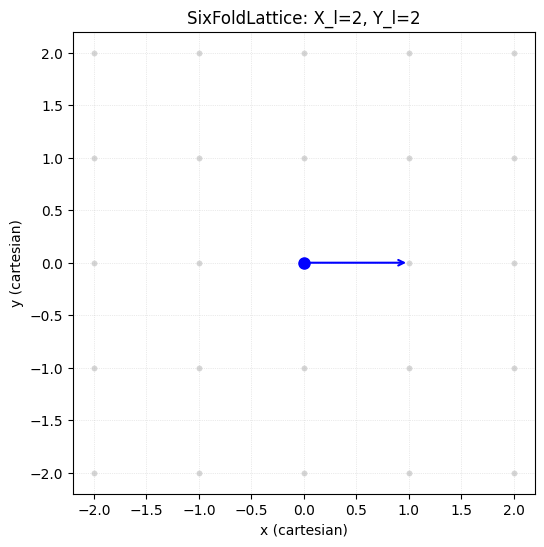

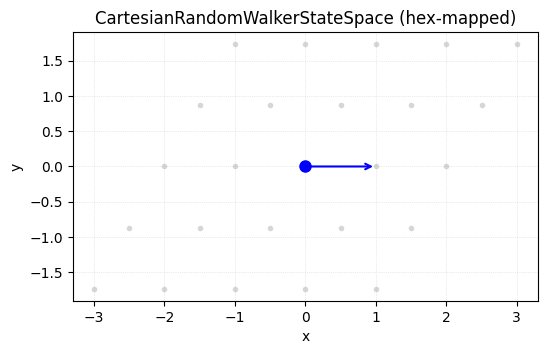

<Axes: title={'center': 'CartesianRandomWalkerStateSpace (hex-mapped)'}, xlabel='x', ylabel='y'>

In [ ]:
# hex (source) space
hex_rw = SixFoldRandomWalkerStateSpace(
    X_l=2, Y_l=2,
    initial_state=SixFoldRandomWalkerState(GridState(0,0), direction=6)
)

# cart (target) space – pick the variant you use:
# 1) If your Cartesian RW state uses dir_idx:
cart_rw = CartesianRandomWalkerStateSpace(
    X_l=3.0, Y_l=3.0,
    step_x=0.5, step_y=(3**0.5)/2.0,  # “nice” hex-aligned steps if you want crisp mapping
    initial_state=CartesianRandomWalkerState(GridState(0,0), 0)  # dir_idx=0
)

# 2) If your Cartesian RW state uses vector directions:
# cart_rw = CartesianRandomWalkerStateSpace(
#     X_l=3.0, Y_l=3.0, step_x=0.5, step_y=(3**0.5)/2.0,
#     initial_state=CartesianRandomWalkerState(GridState(0,0), GridState(0,0))
# )
hex_rw.plot_state_space()

mapper = SixFoldRWToCartesianRW(scale=1.0)

mapped_space = mapper.get_mapping_over_state_space(hex_rw, cart_rw)

mapped_space.plot_state_space()

### Random walker Distance

In [ ]:
class RandomWalkerDistance(StateOperations):
    def __init__(self, scale: float = 1.0) -> None:
        self.scale = float(scale)

    @staticmethod
    def _axial_to_real(q: int, r: int, scale: float) -> Tuple[float, float]:
        x = (q + 0.5 * r) * scale
        y = (math.sqrt(3) * 0.5 * r) * scale
        return x, y

    def apply(self, a: SixFoldRandomWalkerState, b: SixFoldRandomWalkerState) -> float:
        ax, ay = self._axial_to_real(a.position.x, a.position.y, self.scale)
        bx, by = self._axial_to_real(b.position.x, b.position.y, self.scale)
        return math.hypot(ax - bx, ay - by)

### Random Walker Reachable

#### Is allowed State

In [ ]:
class RandomWalkerAllowed(IsAllowedState):
    """
    params:
      - initial_state: SixFoldRandomWalkerState (required)
      - allowed_angles: Set[int] subset of {-1, 0, 60, 120, 180, -60, -120}
                        (-1 means stationary is allowed)
      - scale: float (default 1.0) used for axial→Cartesian projection
      - tol: float (default 1e-9) tolerance for distance comparisons
      - space: SixFoldRandomWalkerStateSpace (optional; not required by logic)
    """

    def __init__(self, params: Dict[str, Any]=None):
      if params is not None:
        super().__init__(params)
        if params["allowed_amgles"] is None:
          self.allowed_angles: Set[int] = set(
              params.get("allowed_angles", {-1, 0, 60, 120, 180, -60, -120})
          )
        self.scale: float = float(params.get("scale", 1.0))
        self.tol: float = float(params.get("tol", 1e-9))
        self.space = params.get("space", None)
        self.angle_tol: float = float(params.get("angle_tol", 0.1))
      else:
        self.allowed_angles: Set[int] = set({-1, 0, 60, 120, 180, -60, -120})
        self.scale: float = 1.0
        self.tol: float = 0.000009
        self.space = None
        self.angle_tol: float =0
    # -------- internal helpers (all as methods) --------

    def _axial_to_real(self, q: int, r: int) -> Tuple[float, float]:
        x = (q + 0.5 * r) * self.scale
        y = (math.sqrt(3) * 0.5 * r) * self.scale
        return x, y

    def _euclid_distance_axial(self, a: SixFoldRandomWalkerState, b: SixFoldRandomWalkerState) -> float:
        ax, ay = self._axial_to_real(a.position.x, a.position.y)
        bx, by = self._axial_to_real(b.position.x, b.position.y)
        return math.hypot(ax - bx, ay - by)

    def _disp_dir_index(self, s_from: SixFoldRandomWalkerState, s_to: SixFoldRandomWalkerState) -> int:
        dq = s_to.position.x - s_from.position.x
        dr = s_to.position.y - s_from.position.y
        return SixFoldRandomWalkerState.DELTA_TO_DIR_INDEX.get((dq, dr), 0)

    def _signed_angle_deg(self, a_idx: int, b_idx: int) -> int:
        """
        Minimal signed angle (in degrees) to rotate from direction b_idx to a_idx.
        Indices are hex directions 1..6 (0 is stationary; if 0 present, return 0).
        Result in {-180, -120, -60, 0, 60, 120}.
        """
        if a_idx == 0 or b_idx == 0:
            return 0
        a = (a_idx - 1) % 6
        b = (b_idx - 1) % 6
        diff = (a - b) % 6
        if diff > 3:
            diff -= 6
        return diff * 60

    def _angle_close(self, angle: float, target: float) -> bool:
        """
        Is 'angle' within ±angle_tol of 'target', modulo 360?
        """
        # normalize difference to (-180, 180]
        d = ((angle - target + 180.0) % 360.0) - 180.0
        return abs(d) <= self.angle_tol

    # -------- required API --------

    def is_state_allowed(self,s0:SixFoldRandomWalkerState, state: SixFoldRandomWalkerState) -> bool:
        # Stationary: same position and zero dir, allowed if -1 present
        if state.position == s0.position:
            return (-1 in self.allowed_angles) and (state.dir_idx == 0)

        # Must be exactly one hex step away under Euclidean metric of mapped hex
        d = self._euclid_distance_axial(state, s0)
        # A single hex step maps to length == self.scale
        if not (abs(d - self.scale) <= self.tol):
            return False

        # Displacement direction index (from s0 to candidate)
        disp_idx = self._disp_dir_index(s0, state)
        if disp_idx == 0:
            return False  # not a valid one-step axial displacement

        # Angle between candidate's momentum and its displacement from s0
        # angle between candidate momentum and displacement
        angle = self._signed_angle_deg(state.dir_idx, disp_idx)
        # check against allowed angles with tolerance
        for a in self.allowed_angles:
            if a == -1:
                continue  # -1 pertains only to stationary case above
            # treat ±180 as equivalent
            if a in (180, -180):
                if self._angle_close(angle, 180.0) or self._angle_close(angle, -180.0):
                    print(f"Checking for state: {state.position.x},{state.position.y},d={state.dir_idx}")
                    print("T")
                    return True
            else:
                if self._angle_close(angle, float(a)):
                  # debug ke liye kiya tha bhai, don't judge pleze ->:(
                    print(f"Checking for state: {state.position.x},{state.position.y},d={state.dir_idx}")
                    print("T")
                    return True
        return False

#### Reachable

In [ ]:
class RandomWalkerReachable(Reachable[SixFoldRandomWalkerState]):
    STATIONARY = -1
    ALL_DEVIATIONS: Set[int] = {-1, 0, 60, 120, 180, -60, -120}
    ANGLE_TO_STEP = {0: 0, 60: 1, -60: -1, 120: 2, -120: -2, 180: 3, -180: -3}

    def __init__(
        self,
        space: SixFoldRandomWalkerStateSpace,
        allowed_deviations: Optional[Set[int]] = None,
        params: Dict[str, Any] = None,
        is_allowed: 'IsAllowedState' = None,
    ) -> None:
        super().__init__(params=params, is_allowed=is_allowed)
        self.space = space
        self.allowed_deviations: Set[int] = (
            set(self.ALL_DEVIATIONS) if allowed_deviations is None else set(allowed_deviations)
        )

    @staticmethod
    def _rotate_dir_idx(base_idx: int, step_delta: int) -> int:
        base = base_idx if base_idx != 0 else 1
        return ((base - 1 + step_delta) % 6) + 1

    @staticmethod
    def _delta_from_idx(idx: int) -> Tuple[int, int]:
        return SixFoldRandomWalkerState.DIR_INDEX_TO_DELTA[idx]

    def allowed_positions(
        self,
        s0: SixFoldRandomWalkerState,
        *,
        allowed_deviations: Optional[Set[int]] = None
    ) -> Set[GridState]:
        devs = self.allowed_deviations if allowed_deviations is None else set(allowed_deviations)
        out: Set[GridState] = set()

        for dev in devs:
            if dev == self.STATIONARY:
                pos = s0.position
                if self.space.contains(SixFoldRandomWalkerState(pos, 0)):
                    out.add(pos)
                continue

            step_delta = self.ANGLE_TO_STEP.get(dev)
            if step_delta is None:
                continue

            ndir = self._rotate_dir_idx(s0.dir_idx, step_delta)
            dq, dr = self._delta_from_idx(ndir)
            pos = GridState(s0.position.x + dq, s0.position.y + dr)

            if self.space.contains(SixFoldRandomWalkerState(pos, ndir)):
                out.add(pos)

        return out

    def reachable_states(
        self,
        s0: SixFoldRandomWalkerState,
        *,
        allowed_deviations: Optional[Set[int]] = None
    ) -> Set[SixFoldRandomWalkerState]:
        positions = self.allowed_positions(s0, allowed_deviations=allowed_deviations)
        states: Set[SixFoldRandomWalkerState] = set()
        for p in positions:
            dq = p.x - s0.position.x
            dr = p.y - s0.position.y
            dir_idx = SixFoldRandomWalkerState.DELTA_TO_DIR_INDEX.get((dq, dr), 0)
            st = SixFoldRandomWalkerState(p, dir_idx)
            if self.space.contains(st):
                if (self.is_allowed is None) or self.is_allowed.is_state_allowed(self.space.get_state(),st):
                    states.add(st)
        return states

    def get_reachable(self, state: SixFoldRandomWalkerState) -> SixFoldRandomWalkerStateSpace:
        R = self.reachable_states(state)
        if not R:
            out_space = copy.deepcopy(self.space)
            out_space.build_from_states({state}, current=state)
            return out_space

        max_q = max(abs(s.position.x) for s in R)
        max_r = max(abs(s.position.y) for s in R)
        init = state if state in R else next(iter(R))
        out_space = SixFoldRandomWalkerStateSpace(max_q, max_r, initial_state=init)
        out_space.build_from_states(R, current=init)
        return out_space

    @staticmethod
    def _axial_to_real(q: int, r: int, scale: float) -> Tuple[float, float]:
        x = (q + 0.5 * r) * scale
        y = (math.sqrt(3) * 0.5 * r) * scale
        return x, y

    def plot_reachable(
        self,
        s0: SixFoldRandomWalkerState,
        *,
        scale: float = 1.0,
        allowed_deviations: Optional[Set[int]] = None,
        ax=None,
        show: bool = True,
        point_kwargs: Optional[dict] = None,
        arrow_kwargs: Optional[dict] = None,
        skip_stationary: bool = True,
        pad_frac: float = 0.1,
    ):
        """
        Plot reachable states as blue dots (mapped via axial→Cartesian).
        For EACH reachable state a, draw an arrow with tail at a and head at a + delta(dir_idx).
        Axes limits include both tails and heads so arrows aren’t clipped.
        """
        import matplotlib.pyplot as plt

        if point_kwargs is None:
            point_kwargs = {"s": 28, "alpha": 0.9, "linewidths": 0.0, "color": "blue", "zorder": 3}
        if arrow_kwargs is None:
            arrow_kwargs = {"arrowstyle": "->", "lw": 1.8, "color": "blue", "mutation_scale": 12, "zorder": 4}

        R = self.reachable_states(s0, allowed_deviations=allowed_deviations)

        created = False
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))
            created = True

        if not R:
            ax.set_title("No reachable states")
            if show and created:
                plt.show()
            return ax

        # Scatter tails (reachable positions)
        tails = [self._axial_to_real(st.position.x, st.position.y, scale) for st in R]
        xs, ys = zip(*tails)
        ax.scatter(xs, ys, **point_kwargs)

        # Compute heads and draw arrows
        heads = []
        for st in R:
            if skip_stationary and st.dir_idx == 0:
                continue
            tail_x, tail_y = self._axial_to_real(st.position.x, st.position.y, scale)
            dq, dr = SixFoldRandomWalkerState.DIR_INDEX_TO_DELTA[st.dir_idx]
            head_x = tail_x + (dq + 0.5 * dr) * scale
            head_y = tail_y + (math.sqrt(3) * 0.5 * dr) * scale
            heads.append((head_x, head_y))
            if (head_x, head_y) != (tail_x, tail_y):
                ax.annotate(
                    "",
                    xy=(head_x, head_y),
                    xytext=(tail_x, tail_y),
                    arrowprops=arrow_kwargs,
                )

        # Expand axes to include arrow heads (prevents clipping)
        all_x = [*xs, *(h[0] for h in heads)]
        all_y = [*ys, *(h[1] for h in heads)]
        xmin, xmax = min(all_x), max(all_x)
        ymin, ymax = min(all_y), max(all_y)
        dx = xmax - xmin
        dy = ymax - ymin
        pad_x = dx * pad_frac if dx > 0 else 1.0 * pad_frac
        pad_y = dy * pad_frac if dy > 0 else 1.0 * pad_frac
        ax.set_xlim(xmin - pad_x, xmax + pad_x)
        ax.set_ylim(ymin - pad_y, ymax + pad_y)

        ax.set_aspect("equal", adjustable="box")
        ax.set_title("Reachable states (tails at each state; arrows = momentum)")
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.grid(True, linestyle=":", linewidth=0.5, alpha=0.5)

        if show and created:
            plt.show()
        return ax

In [ ]:
rwd= RandomWalkerAllowed()
walkerReachable = RandomWalkerReachable(sex,is_allowed=rwd)

Checking for state: 0,1,d=1
T
Checking for state: -1,1,d=2
T
Checking for state: 1,-1,d=5
T
Checking for state: -1,0,d=3
T
Checking for state: 1,0,d=6
T
Checking for state: 0,-1,d=4
T


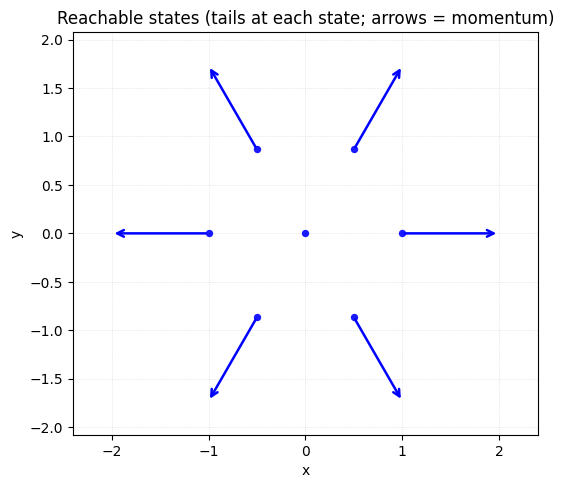

<Axes: title={'center': 'Reachable states (tails at each state; arrows = momentum)'}, xlabel='x', ylabel='y'>

In [ ]:
walkerReachable.plot_reachable(sex.get_state())

In [ ]:
walkerReachable.get_reachable_from_allowed(sex.get_state(),sex)

Checking for state: 1,0,d=0
T
Checking for state: 1,-1,d=1
T
Checking for state: -1,1,d=5
T
Checking for state: 1,0,d=2
T
Checking for state: 1,-1,d=3
T
Checking for state: 0,-1,d=5
T
Checking for state: 0,1,d=1
T
Checking for state: 1,0,d=4
T
Checking for state: 1,-1,d=5
T
Checking for state: -1,1,d=0
T
Checking for state: -1,0,d=2
T
Checking for state: 0,1,d=3
T
Checking for state: 1,0,d=6
T
Checking for state: -1,1,d=2
T
Checking for state: -1,0,d=4
T
Checking for state: 0,-1,d=0
T
Checking for state: 0,1,d=5
T
Checking for state: -1,1,d=4
T
Checking for state: -1,0,d=6
T
Checking for state: 0,-1,d=2
T
Checking for state: 1,0,d=1
T
Checking for state: -1,1,d=6
T
Checking for state: 0,-1,d=4
T
Checking for state: 0,1,d=0
T
Checking for state: 1,0,d=3
T
Checking for state: -1,0,d=1
T
Checking for state: 0,-1,d=6
T
Checking for state: 0,1,d=2
T
Checking for state: -1,1,d=1
T
Checking for state: 1,-1,d=0
T
Checking for state: -1,0,d=3
T
Checking for state: 0,1,d=4
T
Checking for state: 